In [1]:
from pyemd import emd 
from sklearn.feature_extraction import stop_words
from scipy.optimize import curve_fit
from nltk.corpus import reuters
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.externals.joblib import Parallel, delayed
from sklearn import mixture
import seaborn as sns
from sklearn.preprocessing import normalize
import pickle
import random
from sklearn.neighbors import KNeighborsClassifier, BallTree
from sklearn.metrics import accuracy_score, classification_report
import gensim, math
import time
import pandas as pd
import nltk 
from os.path import dirname, abspath
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, cosine_distances
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.corpus import stopwords
import lda
import numpy as np
import gensim
from nltk import word_tokenize
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import string
import os
from scipy.spatial.distance import cosine
from gensim.matutils import softcossim
from scipy.sparse import csc_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import mixture
from collections import Counter
import sklearn.metrics as mt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

figure(num=None, figsize=(10, 8), dpi=70, facecolor='w', edgecolor='k')

# Load word embeddings

In [2]:
def load_glove():    
    print("Loading Glove model")
    f = open('../Benchmark/glove.840B.300d.txt', errors = "ignore")
    glove = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            glove[word] = embedding
        except:
            pass
    print("Glove loading done.")
    return(glove)
def load_word2vec():
    print("Loading Word2vec model")
    word2vec = gensim.models.KeyedVectors.load_word2vec_format('../Benchmark/GoogleNews-vectors-negative300.bin', binary=True)
    print("Word2vec loading done")
    return word2vec
#glove = load_glove()
word2vec = load_word2vec()

Loading Word2vec model
Word2vec loading done


# Local embedding

In [8]:
def tokenize_corpus(data):
    tokenizer = CountVectorizer().build_analyzer()
    return [tokenizer(doc) for doc in data]
corpus = BBCNews.data
model = gensim.models.Word2Vec(
    tokenize_corpus(corpus),
    size=200,
    window=10,
    min_count=0,
    workers=4,
    sg = 1)
model.train(corpus, total_examples=len(corpus), epochs=100)
myvectors = model.wv
del model

# BBC news & BBC sport

In [3]:
class MyDataContainer(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    


def load_BBCNews(topics,folder):
    print("loading bbc news")
    tokenizer = CountVectorizer().build_analyzer()
    cwd = dirname(os.getcwd())+"/Data/"+folder
    BBCNews = MyDataContainer({'data': [],
               'target': []})
    index = 0
    for i, s in enumerate(topics):
        path = cwd+s
        ids = []
        for j, filename in enumerate(os.listdir(path)):
            ids.append(index)
            with open(path+"/"+filename, 'r', encoding="latin-1") as f:
                text = f.read() 
                #text = text+(" "+noises[noise_indices[counter]]+" ")*nn if add_noise else text
                BBCNews.data.append(text)
                BBCNews.target.append(i)
            f.close()
            index += 1 
        BBCNews[s] = ids
        print("{}: {} records".format(s, len(ids)))
    print("{} total records loaded".format(index))
    return BBCNews


topics_bbcnews = ["business", "entertainment", "politics", "sport", "tech"]
topics_bbcsport = ["athletics", "cricket","football","rugby","tennis"]
BBCNews = load_BBCNews(topics_bbcnews,"bbcnews/")
BBCSport = load_BBCNews(topics_bbcsport, "bbcsport/")

loading bbc news
business: 510 records
entertainment: 386 records
politics: 417 records
sport: 511 records
tech: 401 records
2225 total records loaded
loading bbc news
athletics: 101 records
cricket: 124 records
football: 265 records
rugby: 147 records
tennis: 100 records
737 total records loaded


# Reuters news

In [5]:
documents = reuters.fileids()
train_docs = list(filter(lambda doc: doc.startswith("train"),
                        documents));
test_docs = list(filter(lambda doc: doc.startswith("test"),
                       documents));
categories = reuters.categories();
category_docs = reuters.fileids("acq");

train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))

train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]


# 20 news

In [4]:
topics_news20 = [#'comp.graphics',
        #'comp.os.ms-windows.misc',
        'comp.sys.ibm.pc.hardware',
        'rec.autos',
        'rec.motorcycles',
        'rec.sport.baseball',
        'sci.crypt',
        #'sci.electronics',
        'sci.med']

news20_all = fetch_20newsgroups(categories=topics_news20)
news20_noise = random.sample(news20_all.data, len(BBCNews.data))
BBCNews_noised = MyDataContainer({"data": [a+b for a, b in zip(news20_noise, BBCNews.data)],
                            "label": BBCNews.label})
print(len(news20_all.data))

3568


# 20 news mixed

In [6]:
#pickle.dump(texts, open("sample_texts.pickle", "wb"))
texts = pickle.load(open("sample_texts.pickle", "rb"))

min:-0.24397407472133636; max:1.0; mean:0.066214919090271
mu:0.048456486829393394 s:0.04251726180384354
mu:0.06500165531346717 s:0.04397614670608598


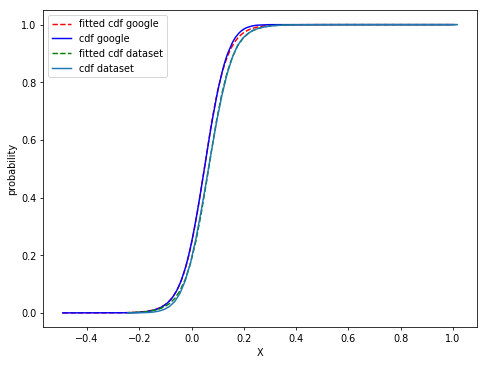

In [98]:
tokenizer = CountVectorizer().build_analyzer()
def within_sum_var(vecs):
    mean = np.mean(vecs, axis = 0)
    var = [np.sum(np.square(v-mean)) for v in vecs]
    return sum(var)
def within_cosine(vecs):
    if len(vecs) == 1:
        return 0
    mean = np.mean(vecs, axis = 0)
    similarity_matrix = cosine_similarity(vecs, [mean])
    return np.mean(similarity_matrix)
def logistic_cdf(x, mu,s):
    return 1/(1+np.exp(-(x-mu)/s))
def logistic_pdf(x, mu,s):
    return np.exp(-(x-mu)/s)/(s*(1+np.exp(-(x-mu)/s))**2)
def ecdf(data):
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return x, y

def epdf(data):
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return x, y

corpus = tokenizer(" ".join(BBCNews.data[:]))+tokenizer(" ".join(news20_all.data[:])) + tokenizer(" ".join(BBCSport.data[:]))#stop_words.ENGLISH_STOP_WORDS#stopwords.words("english")
#corpus = stop_words.ENGLISH_STOP_WORDS
vocabulary = list(set(corpus))
vocabulary = [word for word in vocabulary if word in word2vec]


#vec_c = np.mean([word2vec[word] for word in ["business", "the"]], axis = 0)
x = vocabulary
x_vecs = np.array([word2vec[t] for t in x])
vec_c = word2vec["the"]
dist = cosine_similarity(x_vecs, [vec_c])
#dist = x_vecs.dot(np.array(vec_c))
dist = dist.ravel()
res = zip(dist, x)
sort_res = sorted(res,key=lambda res:res[0], reverse=True)
sorted_scores = np.array([s for s, _ in sort_res])
sorted_words = np.array([w for _, w in sort_res])

print("min:{}; max:{}; mean:{}".format(min(sorted_scores), max(sorted_scores), np.mean(sorted_scores)))
vocab_all = list(word2vec.vocab.keys())
vec_all = [word2vec[word] for word in vocab_all]
#dist = cosine_similarity(vec_all, [vec_c_all])
#vec_c_all = np.mean([word2vec[word] for word in vocab_all], axis = 0)
#scores_all = sorted([word2vec.similarity(word,"the") for word in vocab_all])
#scores_all = sorted(dist.ravel())
#sns.kdeplot(sorted_scores, label = "pdf")
def my_distplot(scores, step, cdf_p, pdf_p, fit, allwords):
    if allwords:
        figure(num=None, figsize=(8, 6), dpi=70, facecolor='w', edgecolor='k')
        ec, ey = ecdf(scores)
        popt_cdf, pcov_cdf = curve_fit(logistic_cdf, ec, ey)
        print("mu:{} s:{}".format(popt_cdf[0],popt_cdf[1]))
        plt.plot(ec, logistic_cdf(ec, *popt_cdf), 'g--', label='fitted cdf google', color = "red")
        plt.plot(ec,ey, label = "cdf google", color = "blue")
        plt.xlabel("X")
        plt.ylabel("probability")
        plt.legend()
    else: 
        xr = np.arange(min(scores), max(scores)+step,step)
        cdf = []
        pdf = []
        for thresh in xr:
            count = sum(scores<=thresh)
            cdf.append(count/len(scores))
            pdf.append((count - sum(scores < thresh-step))/len(scores))
        popt_cdf, pcov_cdf = curve_fit(logistic_cdf, xr, cdf)
        popt_pdf, pcov_pdf = curve_fit(logistic_pdf, xr, pdf)
        print("mu:{} s:{}".format(popt_cdf[0],popt_cdf[1]))
        #figure(num=None, figsize=(8, 6), dpi=70, facecolor='w', edgecolor='k')
        if fit:
            plt.plot(xr, logistic_cdf(xr, *popt_cdf), 'g--', label='fitted cdf dataset')
            #plt.plot(xr, logistic_pdf(xr, *popt_cdf), 'g--', label='fitted pdf')
        if cdf_p:
            plt.plot(xr, cdf, label = "cdf dataset")
        if pdf_p:
            plt.plot(xr, pdf, label = "pdf dataset")
        plt.xlabel("X")
        plt.ylabel("probability")
        plt.legend()
        
my_distplot(scores_all, step = 0.02, cdf_p = True, pdf_p = True, fit = True, allwords = True)   
my_distplot(sorted_scores, step = 0.02, cdf_p = True, pdf_p = False, fit = True, allwords = False)   
plt.show()
#plt.plot(xr, percents)
#plt.xlabel("cosine similarity")
#plt.ylabel(r"$\alpha$")
#plt.show()
#print([w for s,w in sort_res if s > 0.65 and w in swords])
#df = pd.DataFrame(dict(x = np.arange(0,1,0.005), score=percents))

#sns.lmplot("x",'score', data=df, fit_reg=False)




[('economics', 0.3639267202310662), ('airplane', 0.39281145018332908), ('truck', 0.58965783559601559), ('car', 0.43794753789371954), ('finance', 0.48790377234838589), ('blue', 0.024595525417733022), ('laptop', 0.72507011769597973), ('graphics', 0.49475569739568459), ('cow', 0.22831477702171166), ('denotation', 0.038035235940165335), ('capitalism', 0.12361781656609494), ('purple', 0.060796526108818472), ('is', 0.0013283816461689968), ('he', 0.00051040770649457556), ('therefore', 0.0021622673962751193), ('however', 4.4120838200822909e-05), ('also', 0.0003010570710381133)]
illustrations, lithos, ferguson, fevers, doi, morrison, subkey, sidekick, earthquakes, murthy, farmer, michel, scooters, melancholia, subspecialty, cham, offload, manda, ecru, fashionista
0.867989229726


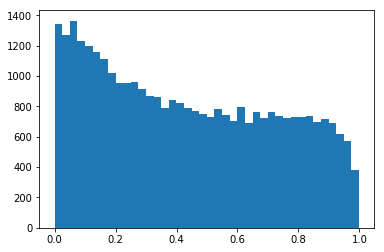

In [291]:
def importance(score):
    return np.clip(1-1/(1+np.exp((0.048-score)/0.0425)),0,1)
def importance_words(words):
    vecs = [word2vec[word] for word in words]
    dist = cosine_similarity(vecs, [word2vec["the"]]).ravel()
    return [np.clip(1-1/(1+np.exp((0.04845-score)/0.042517)),0,1) for score in dist]

def importance_vecs(vecs):
    scores = cosine_similarity(vecs, [word2vec["the"]]).ravel()
    importances = [np.clip(1-1/(1+np.exp((0.04845-score)/0.042517)),0,1) for score in scores]
    #print("len vecs{} len importances{}".format(len(scores),len(importances)))
    return importances
def importance_all(scores):
    importances = [np.clip(1-1/(1+np.exp((0.066-score)/0.0444)),0,1) for score in scores]
    return importances
importances = [importance(score) for score in sorted_scores]
stopwords_w2v = [word for word in stop_words.ENGLISH_STOP_WORDS if word in word2vec]
stopwords_w2v_imp = importance_words(stopwords_w2v)
nonstopwords_w2v = ["economics", "airplane", "truck", "car","finance","blue","laptop","graphics",
                    "cow","denotation", "capitalism", "purple",
                   "is","he","therefore","however","also"]
nonstopwords_w2v_imp = importance_words(nonstopwords_w2v)
print(list(zip(nonstopwords_w2v, nonstopwords_w2v_imp)))
ix = [i for i, score in enumerate(sorted_scores) if  -1<score<0]
thosewords = [sorted_words[i] for i in ix]
samplewords = random.sample(thosewords, 20)
print(", ".join(samplewords))
print(np.mean([importances[i] for i in ix]))
plt.hist(importances, bins = 40)
plt.show()
#print(", ".join(sorted_words[:50]))

Length of document: 87
# clusters: 8
# unique words: 60
[ 0.72015727  0.27984273]
label: 0
size: 24
weight: 0.7201572661329979
importance: 0.2765242114094787
nSize: 0.2926829268292683
blair, election, bbc, constituency, david, monday, parliament, poll, presume, seat, my, queen, live, secretary, general, call, ex, radio, tony, dissolve
label: 1
size: 58
weight: 0.2798427338670022
importance: 0.042051131334208264
nSize: 0.7073170731707317
would, the, not, that, this, he, will, then, we, may, ready, expected, for, what, in, be, meant, on, ask, is, given, shortly, out, very, told, getting, hints, at, has, announcement, his, fresh, clarified, weekend, five, tipped, an, announced, home, clues


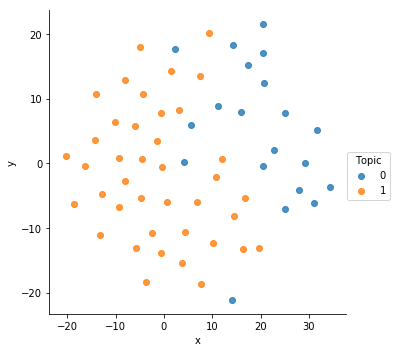

[ 0.52888881  0.1052101   0.3659011 ]
label: 0
size: 19
weight: 0.5288888063504241
importance: 0.22897029732798052
nSize: 0.23170731707317074
election, told, announcement, parliament, constituency, poll, secretary, clarified, general, ask, announced, seat, call, hints, dissolve, tipped
label: 1
size: 51
weight: 0.10521009642365385
importance: 0.01653813538092104
nSize: 0.6219512195121951
the, that, not, this, would, he, then, we, in, will, for, may, be, what, ready, is, on, out, meant, expected, getting, very, at, shortly, given, has, his, weekend, five, fresh, home, an, clues
label: 2
size: 12
weight: 0.36590109722592207
importance: 0.2730223886814256
nSize: 0.14634146341463414
david, blair, bbc, monday, tony, my, live, presume, queen, ex, radio


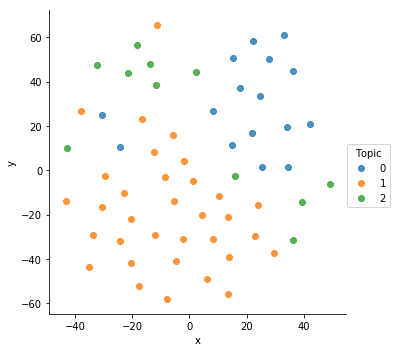

[ 0.03751589  0.26457338  0.31738485  0.38052588]
label: 0
size: 41
weight: 0.037515890900459446
importance: 0.007284498170894969
nSize: 0.5
the, this, that, he, we, then, not, my, in, what, for, be, out, is, on, getting, his, very, has, at, home, five, an, weekend, fresh
label: 1
size: 21
weight: 0.26457338333676766
importance: 0.08703034523378599
nSize: 0.25609756097560976
would, expected, will, hints, may, ask, announced, told, clarified, ready, announcement, presume, tipped, meant, given, shortly, call, clues
label: 2
size: 10
weight: 0.31738484657164306
importance: 0.31059663866793186
nSize: 0.12195121951219512
election, constituency, parliament, poll, seat, secretary, general, dissolve
label: 3
size: 10
weight: 0.3805258791911298
importance: 0.3310108575114568
nSize: 0.12195121951219512
david, blair, bbc, monday, tony, queen, live, ex, radio


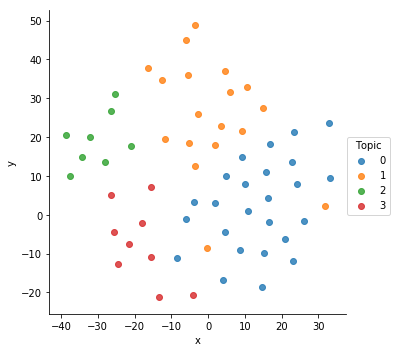

[ 0.03713031  0.41036489  0.01518147  0.32860011  0.20872322]
label: 0
size: 24
weight: 0.03713031054312373
importance: 0.01130132987179707
nSize: 0.2926829268292683
not, would, that, this, may, be, is, we, will, what, very, presume, meant, ask, given, getting, has, an
label: 1
size: 11
weight: 0.41036489423291067
importance: 0.297971490645006
nSize: 0.13414634146341464
david, blair, bbc, monday, tony, my, live, queen, ex, radio
label: 2
size: 25
weight: 0.015181470366625135
importance: 0.0058656521116769444
nSize: 0.3048780487804878
the, then, in, he, on, out, shortly, his, at, for, home, five, weekend, fresh
label: 3
size: 10
weight: 0.328600108727004
importance: 0.31059663866793186
nSize: 0.12195121951219512
election, constituency, parliament, poll, seat, secretary, general, dissolve
label: 4
size: 12
weight: 0.2087232161303364
importance: 0.14624984148054615
nSize: 0.14634146341463414
hints, announced, announcement, expected, clarified, told, tipped, clues, ready, call


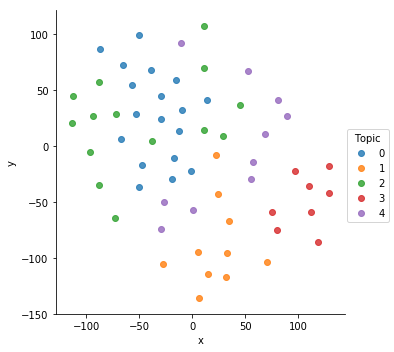

[ 0.24690076  0.32814793  0.01605134  0.00263045  0.01283933  0.39343019]
label: 0
size: 16
weight: 0.24690075508797482
importance: 0.11090258832646326
nSize: 0.1951219512195122
hints, ask, clarified, announced, expected, told, announcement, tipped, presume, given, ready, meant, clues, call
label: 1
size: 10
weight: 0.3281479345332826
importance: 0.31059663866793186
nSize: 0.12195121951219512
election, constituency, parliament, poll, seat, secretary, general, dissolve
label: 2
size: 18
weight: 0.016051342986214245
importance: 0.008802331834079353
nSize: 0.21951219512195122
he, we, my, not, that, what, then, very, his, getting, an
label: 3
size: 12
weight: 0.002630448820480895
importance: 0.0023070794093855568
nSize: 0.14634146341463414
will, would, is, may, be, this, has, for
label: 4
size: 16
weight: 0.012839326041276616
importance: 0.008074014539860785
nSize: 0.1951219512195122
in, the, on, shortly, at, out, home, weekend, five, fresh
label: 5
size: 10
weight: 0.3934301925307708
impo

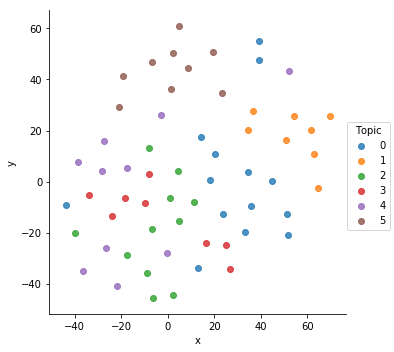

[ 0.16824536  0.31584098  0.00962741  0.02134293  0.42622193  0.00466598
  0.05405541]
label: 0
size: 12
weight: 0.16824536370170368
importance: 0.10896767258951856
nSize: 0.14634146341463414
ask, announced, clarified, told, announcement, expected, presume, call, ready, dissolve
label: 1
size: 9
weight: 0.3158409831047325
importance: 0.3304917650664806
nSize: 0.10975609756097561
election, constituency, parliament, seat, poll, secretary, general
label: 2
size: 16
weight: 0.009627412368565496
importance: 0.0062093517182842456
nSize: 0.1951219512195122
in, the, at, on, shortly, weekend, for, home, five
label: 3
size: 19
weight: 0.02134292565676918
importance: 0.008973723604803606
nSize: 0.23170731707317074
would, not, may, is, that, this, will, be, very, meant, has, given, an
label: 4
size: 10
weight: 0.42622192821044563
importance: 0.3310108575114568
nSize: 0.12195121951219512
david, blair, bbc, monday, tony, queen, live, ex, radio
label: 5
size: 12
weight: 0.00466598119873918
importance

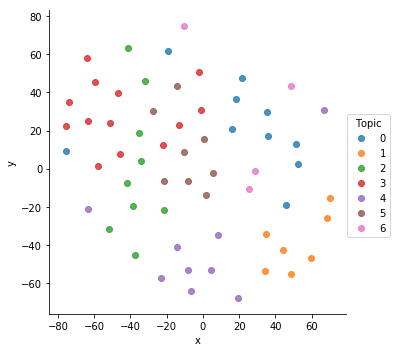

[  1.96232228e-02   4.00243162e-01   1.32330294e-01   3.52268513e-01
   1.88014233e-04   6.62749413e-02   7.46250727e-03   2.16093463e-02]
label: 0
size: 16
weight: 0.019623222768910063
importance: 0.009955954243884685
nSize: 0.1951219512195122
then, out, in, shortly, on, at, home, ready, getting, weekend, five
label: 1
size: 9
weight: 0.4002431615544407
importance: 0.3523304516859073
nSize: 0.10975609756097561
david, blair, bbc, monday, tony, queen, live, ex
label: 2
size: 8
weight: 0.1323302939186192
importance: 0.14067120793158824
nSize: 0.0975609756097561
announcement, announced, clarified, told, call, radio, general
label: 3
size: 9
weight: 0.3522685126502413
importance: 0.35439862877286066
nSize: 0.10975609756097561
election, constituency, parliament, seat, poll, secretary, dissolve
label: 4
size: 7
weight: 0.00018801423302808472
importance: 0.0004983533533471732
nSize: 0.08536585365853659
his, my, he
label: 5
size: 5
weight: 0.06627494134395127
importance: 0.1274370811155284
nSi

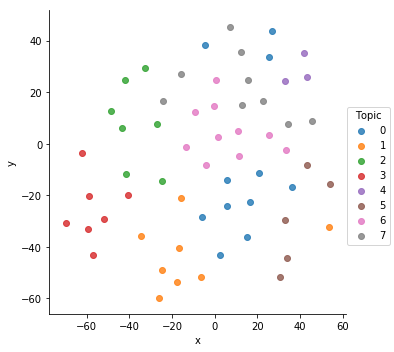

[  3.68724332e-01   1.48192364e-02   2.18571351e-02   1.96797102e-04
   4.16524237e-02   1.29093138e-01   3.29501038e-02   1.88278341e-03
   3.88824051e-01]
label: 0
size: 9
weight: 0.36872433213231726
importance: 0.35439862877286066
nSize: 0.10975609756097561
election, constituency, parliament, seat, poll, secretary, dissolve
label: 1
size: 14
weight: 0.014819236353383867
importance: 0.00830117794242593
nSize: 0.17073170731707318
then, in, out, shortly, on, at, home, getting, weekend, five
label: 2
size: 10
weight: 0.021857135100398283
importance: 0.017540835852330086
nSize: 0.12195121951219512
would, expected, will, may, ready, meant, tipped, given
label: 3
size: 7
weight: 0.0001967971022533084
importance: 0.0004983533533471732
nSize: 0.08536585365853659
his, my, he
label: 4
size: 3
weight: 0.04165242371711187
importance: 0.18682599067134328
nSize: 0.036585365853658534
clues, hints, fresh
label: 5
size: 7
weight: 0.12909313755432425
importance: 0.1634526048851511
nSize: 0.08536585365

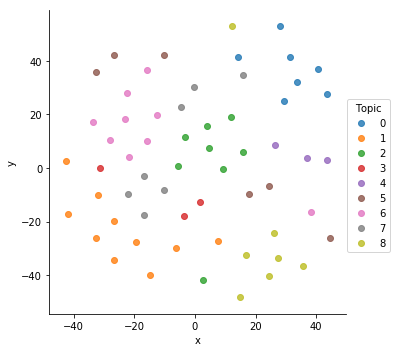

[ 0.12103507  0.19581827  0.3252621   0.01807193  0.02020336  0.02841002
  0.04817631  0.00132412  0.2277633   0.01393553]
label: 0
size: 4
weight: 0.1210350660826606
importance: 0.371966647277212
nSize: 0.04878048780487805
bbc, monday, radio
label: 1
size: 7
weight: 0.19581827231814247
importance: 0.18373922970823683
nSize: 0.08536585365853659
clarified, announced, announcement, told, secretary, general, given
label: 2
size: 8
weight: 0.3252621004327211
importance: 0.3332000025559411
nSize: 0.0975609756097561
election, parliament, constituency, poll, seat, dissolve
label: 3
size: 16
weight: 0.018071926417417273
importance: 0.007573485741354908
nSize: 0.1951219512195122
then, in, out, at, on, shortly, for, home, getting, five, weekend
label: 4
size: 9
weight: 0.020203359462835965
importance: 0.01678883661745323
nSize: 0.10975609756097561
expected, will, would, may, ready, meant, tipped
label: 5
size: 15
weight: 0.02841001842027241
importance: 0.014898474259931453
nSize: 0.1829268292682

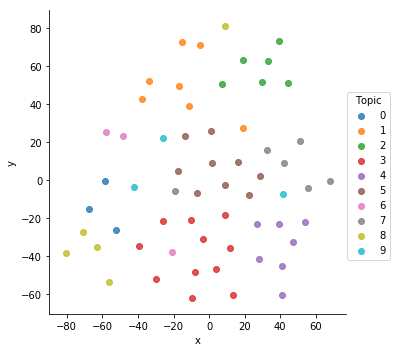

[ 0.01882219  0.04686793  0.32847056  0.32472799  0.00178935  0.00168455
  0.04865153  0.09941502  0.00726377  0.01552893  0.10677819]
label: 0
size: 6
weight: 0.018822187449708587
importance: 0.022158769860471828
nSize: 0.07317073170731707
not, we, what, presume, ask, very
label: 1
size: 7
weight: 0.046867931763938865
importance: 0.06096625424801998
nSize: 0.08536585365853659
live, radio, call, home, weekend
label: 2
size: 8
weight: 0.32847055989374624
importance: 0.3332000025559411
nSize: 0.0975609756097561
election, parliament, constituency, poll, seat, dissolve
label: 3
size: 6
weight: 0.3247279918120116
importance: 0.45875047352757825
nSize: 0.07317073170731707
david, blair, bbc, monday, tony
label: 4
size: 7
weight: 0.0017893471511891046
importance: 0.0029094998768779967
nSize: 0.08536585365853659
will, may, is, be
label: 5
size: 17
weight: 0.0016845471410795064
importance: 0.000940633441624858
nSize: 0.2073170731707317
he, his, my, the, this, that, an, has
label: 6
size: 3
weigh

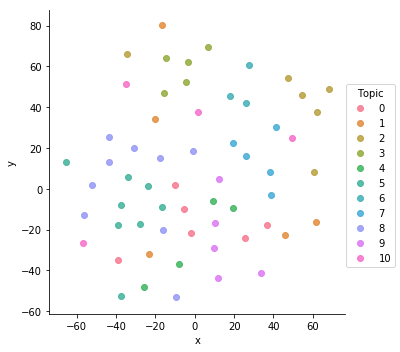

[ 0.00199324  0.05007356  0.28925003  0.33421946  0.10493832  0.05116077
  0.04645255  0.01138823  0.01912166  0.02548416  0.02219612  0.0437219 ]
label: 0
size: 6
weight: 0.001993236117975548
importance: 0.0034199011706610993
nSize: 0.07317073170731707
is, be, may, has
label: 1
size: 3
weight: 0.050073562866724146
importance: 0.18682599067134328
nSize: 0.036585365853658534
clues, hints, fresh
label: 2
size: 7
weight: 0.2892500250887499
importance: 0.36557385229151124
nSize: 0.08536585365853659
election, constituency, parliament, poll, seat
label: 3
size: 6
weight: 0.33421945815936865
importance: 0.45875047352757825
nSize: 0.07317073170731707
david, blair, bbc, monday, tony
label: 4
size: 5
weight: 0.10493832231233882
importance: 0.1603556964307739
nSize: 0.06097560975609756
secretary, clarified, told, general, given
label: 5
size: 10
weight: 0.05116077196567069
importance: 0.04553702533152069
nSize: 0.12195121951219512
my, he, his, then, getting, ex
label: 6
size: 12
weight: 0.0464525

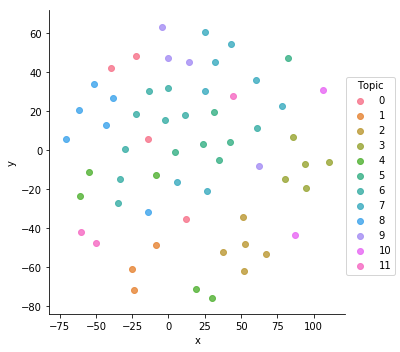

[ 0.01165587  0.04177931  0.04958496  0.08696113  0.39428837  0.01328294
  0.2864276   0.01893508  0.01497316  0.00197379  0.02405592  0.02904398
  0.02703791]
label: 0
size: 4
weight: 0.011655872114596271
importance: 0.034803355069392104
nSize: 0.04878048780487805
ask, call, presume
label: 1
size: 8
weight: 0.04177930620578515
importance: 0.06237457026539975
nSize: 0.0975609756097561
his, my, he, ex
label: 2
size: 3
weight: 0.049584958174818325
importance: 0.18682599067134328
nSize: 0.036585365853658534
clues, hints, fresh
label: 3
size: 4
weight: 0.08696112748055354
importance: 0.1947434070474018
nSize: 0.04878048780487805
secretary, told, clarified, general
label: 4
size: 7
weight: 0.39428836726173655
importance: 0.41936577145588055
nSize: 0.08536585365853659
david, blair, bbc, monday, tony, queen
label: 5
size: 16
weight: 0.013282943076591173
importance: 0.005949245749902498
nSize: 0.1951219512195122
then, in, the, shortly, out, on, at, home, weekend, five
label: 6
size: 7
weight: 

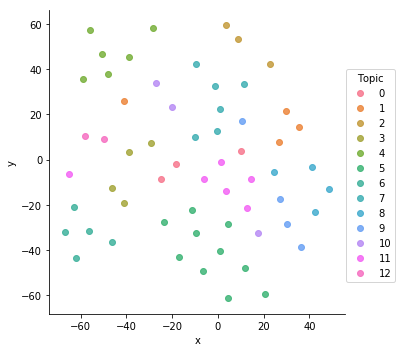

[  3.33548371e-01   2.88669233e-01   6.79330520e-03   3.09342638e-02
   5.55903285e-03   4.99730190e-02   4.21062786e-02   7.27456045e-02
   1.20620584e-03   4.65813905e-02   9.49830122e-02   7.65880408e-05
   1.89241728e-02   7.89952200e-03]
label: 0
size: 6
weight: 0.33354837127205994
importance: 0.45875047352757825
nSize: 0.07317073170731707
david, blair, bbc, monday, tony
label: 1
size: 7
weight: 0.28866923335370315
importance: 0.36557385229151124
nSize: 0.08536585365853659
election, constituency, parliament, poll, seat
label: 2
size: 5
weight: 0.006793305199983627
importance: 0.013002124536810017
nSize: 0.06097560975609756
given, getting, for, meant
label: 3
size: 7
weight: 0.03093426376229794
importance: 0.039175487598737145
nSize: 0.08536585365853659
not, presume, dissolve, that, then
label: 4
size: 10
weight: 0.0055590328453462585
importance: 0.004957922284097416
nSize: 0.12195121951219512
in, at, out, on, weekend, five
label: 5
size: 3
weight: 0.049973019015609826
importance: 

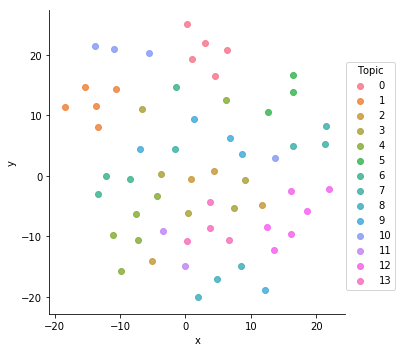

[  1.53748843e-02   2.10365513e-02   7.06512218e-02   7.18989969e-04
   3.95712617e-01   1.98091636e-03   3.45464724e-01   2.85633181e-04
   1.00185307e-03   7.24414367e-02   1.69358506e-02   1.05012711e-02
   1.95590378e-02   2.83350129e-02   0.00000000e+00]
label: 0
size: 2
weight: 0.015374884318512314
importance: 0.13722824723353833
nSize: 0.024390243902439025
hints, fresh
label: 1
size: 5
weight: 0.021036551318936222
importance: 0.040432206393156034
nSize: 0.06097560975609756
poll, weekend, home, five
label: 2
size: 6
weight: 0.07065122182022672
importance: 0.09757916114780914
nSize: 0.07317073170731707
ask, call, told, given, ex
label: 3
size: 7
weight: 0.0007189899692128344
importance: 0.001142949845283986
nSize: 0.08536585365853659
an, this, the, general
label: 4
size: 7
weight: 0.3957126172492664
importance: 0.41936577145588055
nSize: 0.08536585365853659
david, blair, bbc, monday, tony, queen
label: 5
size: 6
weight: 0.0019809163626289712
importance: 0.0034199011706610993
nSize

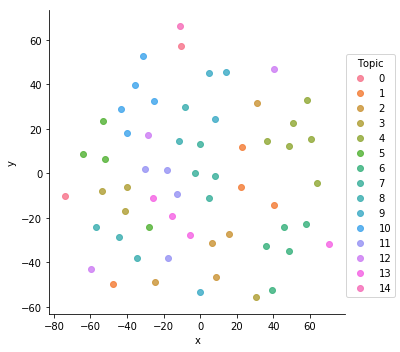

[  3.51360374e-02   4.60715156e-03   5.01921259e-03   9.52624954e-02
   3.52475586e-03   2.90500882e-01   2.25880014e-02   3.14244971e-01
   2.57028834e-04   1.04391934e-01   5.44005668e-02   4.26443221e-03
   5.15333775e-02   1.26410356e-02   3.56683940e-04   1.27143423e-03]
label: 0
size: 10
weight: 0.03513603739307632
importance: 0.028786271575589144
nSize: 0.12195121951219512
that, not, what, this, the, dissolve
label: 1
size: 3
weight: 0.004607151557227016
importance: 0.023733272601943634
nSize: 0.036585365853658534
weekend, home
label: 2
size: 3
weight: 0.005019212592626169
importance: 0.017237308740298718
nSize: 0.036585365853658534
given, getting, meant
label: 3
size: 4
weight: 0.09526249543460603
importance: 0.194449164996397
nSize: 0.04878048780487805
announced, clarified, announcement, told
label: 4
size: 9
weight: 0.0035247558555929585
importance: 0.0030262368745991863
nSize: 0.10975609756097561
will, may, would, is, be, has
label: 5
size: 6
weight: 0.29050088185238987
impo

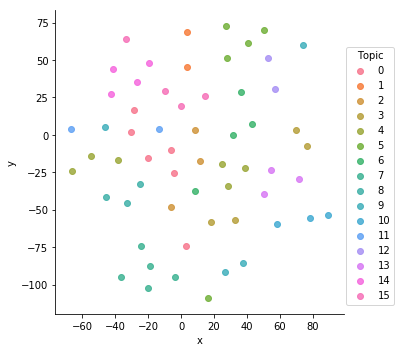

[ 0.86730613  0.13269387]
label: 0
size: 75
weight: 0.8673061283166138
importance: 0.09790291476452322
nSize: 0.9146341463414634
not, the, would, that, this, then, he, we, what, ask, my, presume, will, may, be, in, for, ready, meant, expected, out, shortly, on, told, very, is, given, hints, monday, his, getting, call, at, announcement, clarified, live, weekend, home, has, fresh, david, blair, general, tipped, an, five, announced, ex, clues, radio, queen, tony, bbc, secretary, dissolve
label: 1
size: 7
weight: 0.13269387168338617
importance: 0.36557385229151124
nSize: 0.08536585365853659
election, constituency, parliament, poll, seat


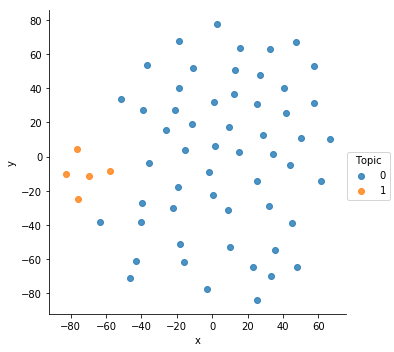

[ 0.01322167  0.95508595  0.03169238]
label: 0
size: 2
weight: 0.01322166568023575
importance: 0.24219806290189427
nSize: 0.024390243902439025
announcement, announced
label: 1
size: 78
weight: 0.9550859513745756
importance: 0.0994113210205667
nSize: 0.9512195121951219
not, the, that, would, he, then, this, what, we, ask, in, my, presume, be, will, may, for, ready, meant, expected, told, on, is, out, very, given, shortly, his, getting, election, hints, at, call, weekend, home, live, general, fresh, monday, clarified, parliament, seat, has, constituency, five, tipped, an, poll, clues, blair, ex, queen, radio, secretary, dissolve, tony
label: 2
size: 2
weight: 0.03169238294518859
importance: 0.5805496783619205
nSize: 0.024390243902439025
bbc, david


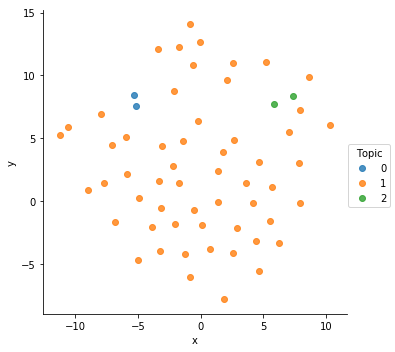

/Users/schen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


[ 0.          0.03679433  0.93040441  0.03280126]
label: 0
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
poll
label: 1
size: 4
weight: 0.036794328642065874
importance: 0.16280576129126967
nSize: 0.04878048780487805
announced, announcement, clarified, expected
label: 2
size: 75
weight: 0.9304044125307388
importance: 0.09976290240352109
nSize: 0.9146341463414634
not, the, that, then, he, would, this, what, we, ask, my, in, be, for, presume, may, will, ready, meant, out, very, is, on, his, shortly, told, given, getting, at, call, hints, election, home, weekend, live, monday, fresh, general, seat, has, parliament, an, constituency, five, tipped, blair, clues, queen, ex, radio, secretary, dissolve, tony
label: 3
size: 2
weight: 0.03280125882719546
importance: 0.5805496783619205
nSize: 0.024390243902439025
bbc, david


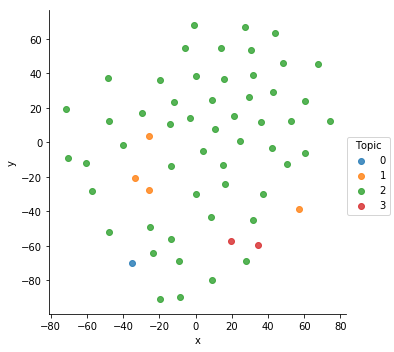

[ 0.92780155  0.01584654  0.03413457  0.          0.02221733]
label: 0
size: 75
weight: 0.9278015548964513
importance: 0.09382759777376225
nSize: 0.9146341463414634
the, not, would, that, he, this, then, we, what, ask, in, will, for, my, be, ready, presume, may, meant, expected, told, is, given, on, very, shortly, out, his, getting, election, announcement, call, at, weekend, general, home, has, clarified, live, seat, five, constituency, parliament, poll, an, tipped, fresh, announced, ex, radio, secretary, queen, blair, tony
label: 1
size: 2
weight: 0.015846543600856515
importance: 0.26951286764956983
nSize: 0.024390243902439025
clues, hints
label: 2
size: 2
weight: 0.03413456979199666
importance: 0.5805496783619205
nSize: 0.024390243902439025
bbc, david
label: 3
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
dissolve
label: 4
size: 2
weight: 0.02221733171069564
importance: 0.7557303260185594
nSize: 0.024390243902439025
monday


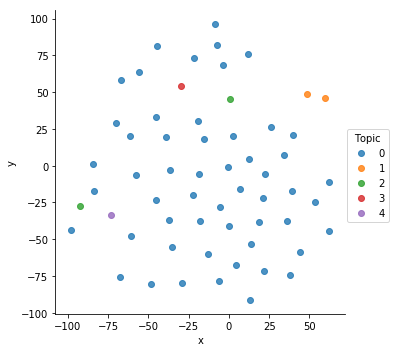

[ 0.  1.  0.  0.  0.  0.]
label: 0
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
clues
label: 1
size: 77
weight: 1.0
importance: 0.1027586316030022
nSize: 0.9390243902439024
not, the, that, would, this, he, then, we, ask, what, my, presume, will, in, be, may, for, ready, meant, expected, told, on, shortly, is, very, given, out, getting, announcement, call, his, at, hints, weekend, monday, election, clarified, general, live, home, has, fresh, tipped, five, poll, announced, an, ex, blair, david, constituency, radio, secretary, dissolve, tony
label: 2
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
queen
label: 3
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
bbc
label: 4
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
parliament
label: 5
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
seat


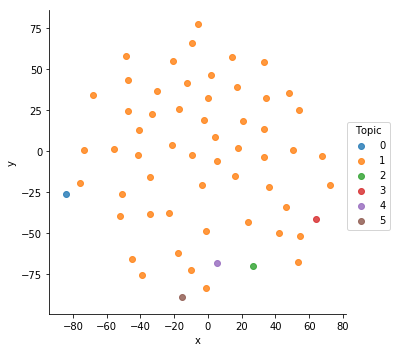

[ 0.04124077  0.38012757  0.01196169  0.56666998  0.          0.          0.        ]
label: 0
size: 2
weight: 0.04124076891380861
importance: 0.5805496783619205
nSize: 0.024390243902439025
bbc, david
label: 1
size: 22
weight: 0.3801275660018615
importance: 0.1714211683926528
nSize: 0.2682926829268293
he, election, constituency, general, told, secretary, that, his, seat, my, clarified, what, announcement, radio
label: 2
size: 14
weight: 0.011961688003895153
importance: 0.008845283100503698
nSize: 0.17073170731707318
would, is, may, will, not, this, be, very, has, an
label: 3
size: 41
weight: 0.5666699770804348
importance: 0.09606047839190147
nSize: 0.5
then, the, ready, ask, in, out, expected, we, shortly, for, hints, monday, on, at, presume, weekend, meant, given, home, getting, call, clues, tipped, live, five, fresh, announced, blair, ex, tony, queen
label: 4
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
dissolve
label: 5
size: 1
weight: 0.0
importance: 1.0
nSize: 0

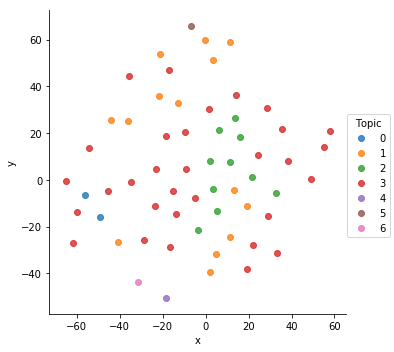

[ 0.1653683   0.64907979  0.          0.03554752  0.          0.04402849
  0.          0.1059759 ]
label: 0
size: 5
weight: 0.16536829620767363
importance: 0.5483065096395822
nSize: 0.06097560975609756
parliament, election, constituency
label: 1
size: 60
weight: 0.649079793546836
importance: 0.061900830630419935
nSize: 0.7317073170731707
the, then, he, that, this, we, my, what, in, ask, for, ready, out, his, be, on, at, getting, shortly, very, presume, meant, told, given, home, weekend, call, live, monday, an, five, has, fresh, general, seat, tipped, radio, ex, queen, secretary, tony
label: 2
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
dissolve
label: 3
size: 8
weight: 0.03554752244137235
importance: 0.03909589985675575
nSize: 0.0975609756097561
will, may, would, expected, not, is, hints
label: 4
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
clues
label: 5
size: 3
weight: 0.04402849229338205
importance: 0.21386254899050902
nSize: 0.0365853658536585

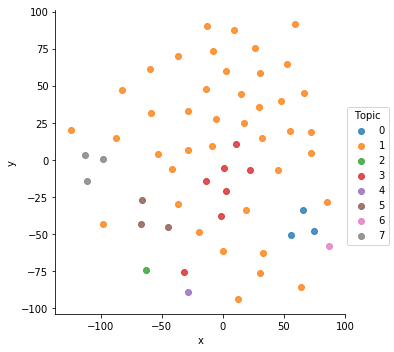

[ 0.15449932  0.          0.82526531  0.          0.          0.          0.
  0.02023537  0.        ]
label: 0
size: 18
weight: 0.15449932006916223
importance: 0.06822515578884783
nSize: 0.21951219512195122
for, ask, out, in, getting, at, on, home, call, given, five, david, ex
label: 1
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
poll
label: 2
size: 56
weight: 0.8252653121972655
importance: 0.0872248386489242
nSize: 0.6829268292682927
not, would, that, the, he, this, we, then, what, my, will, presume, may, be, ready, meant, is, expected, very, told, his, shortly, hints, weekend, clarified, has, general, an, monday, live, election, tipped, fresh, seat, blair, queen, radio, secretary, tony
label: 3
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
bbc
label: 4
size: 1
weight: 0.0
importance: 0.0
nSize: 0.012195121951219513
constituency
label: 5
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
dissolve
label: 6
size: 1
weight: 0.0
importanc

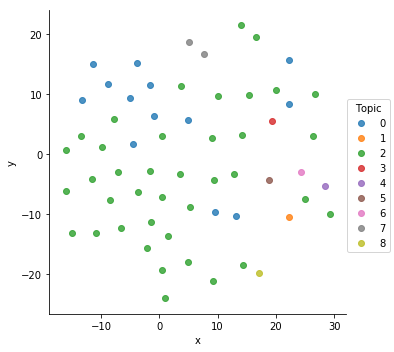

[  5.93025085e-05   1.58676166e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   7.23206834e-01   0.00000000e+00   1.18057698e-01
   0.00000000e+00   0.00000000e+00]
label: 0
size: 2
weight: 5.9302508466293235e-05
importance: 0.0006724219743419191
nSize: 0.024390243902439025
my, we
label: 1
size: 19
weight: 0.15867616559482225
importance: 0.06050696829731917
nSize: 0.23170731707317074
for, then, out, ask, in, on, getting, given, at, home, call, five, ex, announced
label: 2
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
parliament
label: 3
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
poll
label: 4
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
david
label: 5
size: 51
weight: 0.7232068340163748
importance: 0.08260845835470154
nSize: 0.6219512195121951
not, would, that, the, this, he, will, may, what, be, is, presume, ready, expected, meant, told, very, announcement, shortly, clarified, hints, gener

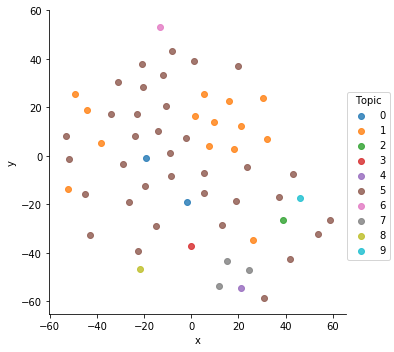

[ 0.00559482  0.          0.04375637  0.02732278  0.89877238  0.          0.
  0.          0.          0.          0.02455365]
label: 0
size: 3
weight: 0.005594820996434207
importance: 0.023212964326300784
nSize: 0.036585365853658534
we, very, this
label: 1
size: 1
weight: 0.0
importance: 0.0
nSize: 0.012195121951219513
constituency
label: 2
size: 2
weight: 0.043756373856725574
importance: 0.43161445680074234
nSize: 0.024390243902439025
david, blair
label: 3
size: 2
weight: 0.027322777562840184
importance: 0.26951286764956983
nSize: 0.024390243902439025
clues, hints
label: 4
size: 67
weight: 0.8987723806411626
importance: 0.0649550717651004
nSize: 0.8170731707317073
the, not, would, that, he, then, ask, what, will, in, for, may, be, my, ready, meant, on, expected, presume, told, shortly, given, is, getting, out, his, at, weekend, call, home, has, live, general, five, clarified, fresh, election, tipped, an, monday, poll, ex, radio, secretary, tony
label: 5
size: 1
weight: 0.0
importance

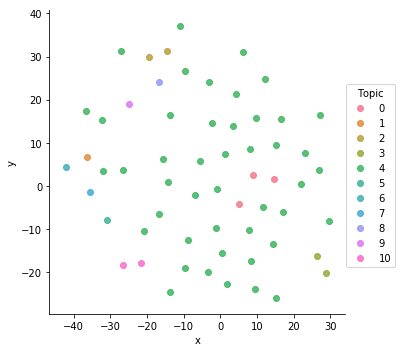

[ 0.02167208  0.0070012   0.06425898  0.          0.          0.
  0.11186767  0.76229337  0.0329067   0.          0.          0.        ]
label: 0
size: 3
weight: 0.021672079814716663
importance: 0.08235612465282256
nSize: 0.036585365853658534
tipped, clarified, given
label: 1
size: 7
weight: 0.007001199958788909
importance: 0.00901240525553324
nSize: 0.08536585365853659
will, expected, would, may, ready
label: 2
size: 2
weight: 0.06425897996944446
importance: 0.5805496783619205
nSize: 0.024390243902439025
bbc, david
label: 3
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
clues
label: 4
size: 1
weight: 0.0
importance: 0.0
nSize: 0.012195121951219513
constituency
label: 5
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
dissolve
label: 6
size: 5
weight: 0.11186766676365563
importance: 0.2901817636730622
nSize: 0.06097560975609756
election, poll, parliament
label: 7
size: 55
weight: 0.7622933738786885
importance: 0.06108901223500104
nSize: 0.6707317073170

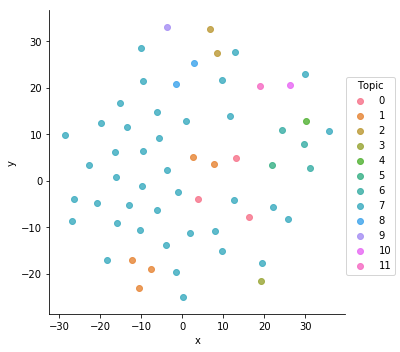

[ 0.13033032  0.          0.11732094  0.06767305  0.01120375  0.19373475
  0.47973719  0.          0.          0.          0.          0.          0.        ]
label: 0
size: 4
weight: 0.13033031728297498
importance: 0.3792040701888599
nSize: 0.04878048780487805
david, blair, monday
label: 1
size: 1
weight: 0.0
importance: 0.0
nSize: 0.012195121951219513
shortly
label: 2
size: 9
weight: 0.11732093531257663
importance: 0.08076353701723264
nSize: 0.10975609756097561
may, hints, will, expected, clues, would, tipped, fresh
label: 3
size: 5
weight: 0.06767304936839665
importance: 0.12719960909026148
nSize: 0.06097560975609756
announcement, announced, weekend, five
label: 4
size: 8
weight: 0.011203754535992433
importance: 0.013039205029236011
nSize: 0.0975609756097561
is, be, has, live, at
label: 5
size: 5
weight: 0.19373474888108488
importance: 0.4855302478583103
nSize: 0.06097560975609756
election, poll, constituency
label: 6
size: 44
weight: 0.4797371946189744
importance: 0.051134438787172

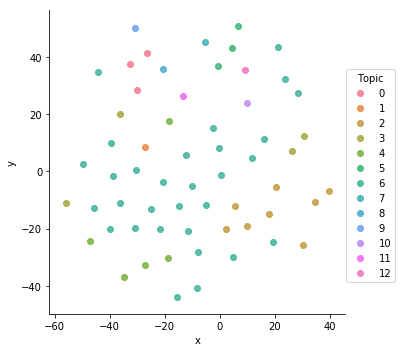

[ 0.89844907  0.          0.          0.          0.          0.          0.
  0.          0.10155093  0.          0.          0.          0.          0.        ]
label: 0
size: 67
weight: 0.8984490743880978
importance: 0.049183782062859144
nSize: 0.8170731707317073
the, not, that, would, this, he, then, we, what, will, for, be, my, in, ask, ready, may, meant, on, presume, is, expected, out, very, given, shortly, getting, told, at, his, call, weekend, announcement, has, live, home, an, monday, clarified, five, fresh, general, announced, seat, radio, queen, blair
label: 1
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
bbc
label: 2
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
david
label: 3
size: 1
weight: 0.0
importance: 0.0
nSize: 0.012195121951219513
constituency
label: 4
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
secretary
label: 5
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.0121951

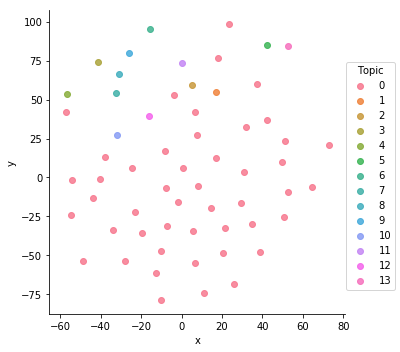

[ 0.00614031  0.04444527  0.13104082  0.          0.          0.          0.
  0.3057358   0.          0.29173446  0.18212817  0.          0.03877515
  0.          0.        ]
label: 0
size: 2
weight: 0.006140313388163468
importance: 0.038353735020674684
nSize: 0.024390243902439025
tipped, expected
label: 1
size: 10
weight: 0.044445273504313716
importance: 0.027856800055177117
nSize: 0.12195121951219512
his, he, my, then, shortly, radio
label: 2
size: 19
weight: 0.13104082388355687
importance: 0.027526348492659693
nSize: 0.23170731707317074
not, would, this, that, may, we, what, will, presume, meant, very, an, hints, weekend
label: 3
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
clarified
label: 4
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
dissolve
label: 5
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
secretary
label: 6
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
clues
label: 7
s

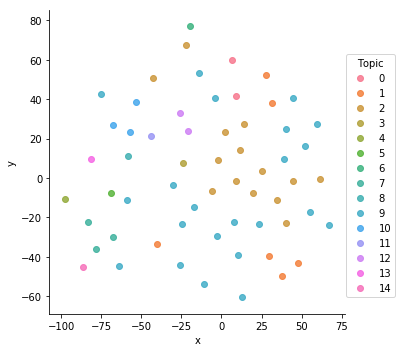

[ 0.          0.00301578  0.          0.2424226   0.03390103  0.          0.
  0.          0.          0.          0.          0.          0.
  0.68293624  0.03772435  0.        ]
label: 0
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
parliament
label: 1
size: 5
weight: 0.003015779032354604
importance: 0.004639577994738797
nSize: 0.06097560975609756
will, would, may, expected
label: 2
size: 1
weight: 0.0
importance: 1.0
nSize: 0.012195121951219513
dissolve
label: 3
size: 22
weight: 0.24242259956988524
importance: 0.05975000737168074
nSize: 0.2682926829268293
we, this, not, what, that, my, he, presume, very, monday, blair, weekend, an
label: 4
size: 2
weight: 0.03390103369249553
importance: 0.24219806290189427
nSize: 0.024390243902439025
announcement, announced
label: 5
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
tony
label: 6
size: 1
weight: 0.0
importance: 0.7557303260185594
nSize: 0.012195121951219513
queen
label: 7


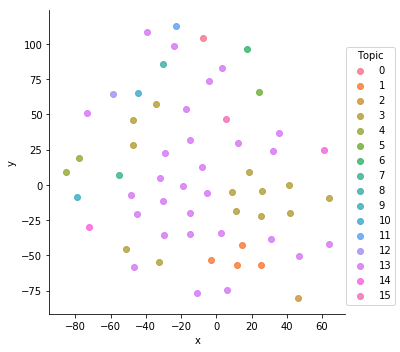

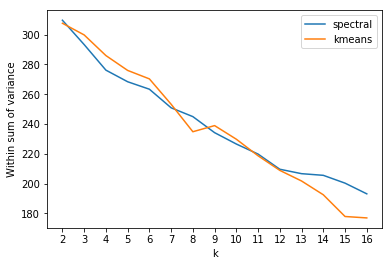

In [153]:
doc = "Economics, economy, finance, capitalism, macroeconomics, money, consumer, euro, dollar, bank, rich, \
Dog, cat, goat, cow, horse,sheep, chicken, rabbit, fox,tiger,\
Red, orange, yellow, green,blue, purple, white, black,\
Football, basketball, baseball, tennis, swimming, archery,\
Denote, denotes, denotation,denoted, denoting, \
about, above, because, between, could, from, where,under, until, their, same, is, through, after, each,\
fashion, design, dressing, designer, stylish, artistic"
it1 = "Dog, cat, goat, cow, horse, sheep,chicken, rabbit, fox, tiger,\
Economics, economy, finance,capitalism, macroeconomics,money, consumer, euro, dollar,bank,\
Red, orange, yellow, green,blue, purple, white, black,pink, brown"

it2 = "Economics, economy, finance,capitalism, macroeconomics, money, consumer, euro, dollar,bank, rich,\
Dog, cat, goat, cow, horse,sheep, chicken, rabbit, fox, tiger,\
Red, orange, yellow, green,blue, purple, white, black,\
Football, basketball, baseball,tennis, swimming, archery,\
Denote, denotes, denotation,denoted, denoting,\
about, above, because, between,could, from, where, under,until, their, same, is,through, after, each, \
however, as, perhaps, therefore,\
fashion, design, dressing,designer, stylish, artistic"

it3 = "Blunkett hints at election call Ex-Home secretary David Blunkett has given fresh clues that the general election will be announced on Monday. He told BBC\
 Radio Five Live: I'm out in my constituency getting ready for what we presume will\
 be an announcement very shortly at the weekend. He clarified that he meant he would\
 be in his Sheffiled seat this weekend, not that he expected an election call then. \
 Tony Blair is tipped to ask the Queen on Monday to dissolve Parliament ready for a 5 \
 May poll."

it4 = "Lacroix label bought by US firm\
 Luxury goods group LVMH has sold its loss-making Christian Lacroix clothing label to a US investment group.\
 The Paris-based firm has been shedding non-core businesses and focusing on its most profitable brands including\
 Moet Chandon champagne and Louis Vuitton. LVMH said the French designer's haute couture and ready-to-wear labels\
 had been purchased by the Falic Group for an unspecified sum. The Falic Group bought two cosmetics labels from LVMH\
 in 2003. The sale of the Lacroix label comes as many fashion houses are struggling to make money from their expensive\
 haute couture ranges. The Florida-based Falic group, which also runs a chain of 90 duty free stores in the US, said\
 it planned to expand the brand by opening new stores. Mr Lacroix said he planned to stay at the label he founded in\
 1987 although exact details are still to be confirmed ."
def within_var(vecs):
    mean = np.mean(vecs, axis = 0)
    var =[np.sum(np.square(v-mean)) for v in vecs]
    return sum(var)
def within_std(vecs):
    mean = np.mean(vecs, axis = 0)
    var = [np.sqrt(np.sum(np.square(v-mean))) for v in vecs]
    var = np.sum(var)/len(var)
    return var

def within_cosine(vecs):
    if len(vecs) == 1:
        return 0
    mean = np.mean(vecs, axis = 0)
    similarity_matrix = cosine_similarity(vecs, [mean])
    return np.mean(similarity_matrix)
swords_str = " ".join(stopwords.words("english"))
label1 = ["animals"]*10 + ["economics"]*10+["colors"]*10
label2 = ["economics"]*11+["animals"]*10+["colors"]*8+["sports"]*6+["variations"]*5 + ["stopwords"]*19 + ["fashion"]*6
wordembedding = word2vec
label = label1
def test( dataset, doc_id, synthetic, stop_words, n_clusters, loop, vis, unique,models, groundtruth):
    text = it3 if synthetic else dataset[doc_id]
    tokenizer = CountVectorizer(stop_words = "english").build_analyzer() if stop_words else CountVectorizer().build_analyzer() 
    text = tokenizer(text)
    
    print("Length of document: {}".format(len(text)))
    text = [t for t in text if t in wordembedding]
    word_counter = Counter(text)
    word_counts = np.array(list(word_counter.values()))
    unique_text = np.array(list(word_counter.keys()))
    vecs = np.array([wordembedding[w] for w in unique_text])
    num_clusters = n_clusters if n_clusters > 0 else math.floor(np.cbrt(len(unique_text)))
    print("# clusters: {}".format(num_clusters))
    print("# unique words: {}".format(len(vecs)))
    results_sil = []
    results_var = []
    for model in models:
        sil_coef = []
        sum_var = []
        similarity_matrix = cosine_similarity(vecs).clip(0,1)
        #print(similarity_matrix)
        n_clusters_loop = range(2, 2*num_clusters+1) if loop else range(num_clusters, num_clusters+1)
        for i in n_clusters_loop:
            if model == "kmeans":
                sc = KMeans(n_clusters = i, precompute_distances = True, 
                            n_init = 10, max_iter = 1000, algorithm = "full")
                sc.fit(vecs)
                distance_matrix = cosine_distances(vecs)
                #within_var.append(sc.inertia_)
            elif model == "spectral":
                sc = SpectralClustering(i, affinity='precomputed', 
                                        assign_labels = "discretize", 
                                        n_init=10)     
                sc.fit(similarity_matrix)
                distance_matrix = cosine_distances(vecs)
            elif model == "dbscan":
                sc = AgglomerativeClustering(
                                            n_clusters=i).fit(vecs)
                distance_matrix =  2-similarity_matrix
            elif model == "ggm":
                dpgmm = mixture.BayesianGaussianMixture(n_components=num_clusters, covariance_type='full').fit(vecs)
                sc.labels_ = dpgmm.predict(vecs)
                distance_matrix =  2-similarity_matrix
            
            #sc.labels = random.choices(range(num_clusters), k = len(vecs))
            silhoutte_score = silhouette_score(distance_matrix, sc.labels_, metric = 'precomputed')
            non_empty_clusters = np.array(list(set(sc.labels_)))
            indices = [np.where(sc.labels_ == j) if j in non_empty_clusters 
                                                               else [] for j in range(i)]
            sizes = [sum(word_counts[indices[j]]) for j in non_empty_clusters]
            weightings =np.array([ sum(importance_vecs(vecs[indices[j]]))/len(indices[j])*np.log2(sizes[j])  for j in non_empty_clusters])
            weightings = weightings/sum(weightings)
            print(weightings)
            sil_coef.append(silhoutte_score)
            
            if model == "spectral" or model == "kmeans":
                a = 0
            withinsumvar = 0
            for j in non_empty_clusters: 
                words = unique_text[indices[j]].tolist()
                centroid = np.mean(vecs[indices[j]], axis = 0)
                dist = cosine_similarity(vecs[indices[j]], [centroid])
                res = zip(dist, words)
                sort_res = sorted(res,key=lambda res:res[0], reverse=True)
                words_sorted = [t for _, t in sort_res]
                print("label: {}".format(j))
                print("size: {}".format(sizes[j]))
                print("weight: {}".format(weightings[j]))
                print("importance: {}".format(sum(importance_vecs(vecs[indices[j]]))/len(vecs[indices[j]])))
                print("nSize: {}".format(sizes[j]/sum(sizes)))
                print(", ".join(words_sorted[:]))
                withinsumvar = withinsumvar + within_var(vecs[indices[j]])
                #print(", ".join(words_sorted[:]))
            sum_var.append(withinsumvar)
            if vis == "tsne":
                X_embedded = TSNE(n_iter = 1000,
                          metric = "precomputed").fit_transform(distance_matrix)
            else:
                X_embedded = decomposition.PCA(n_components=2, svd_solver = "full").fit_transform(vecs)
            df = pd.DataFrame(X_embedded)
            df['Topic'] = label if groundtruth else sc.labels_
            df.columns = ['x', 'y', 'Topic']
            #df.columns = ['x', 'y']
            sns.lmplot(x="x", y="y", hue = 'Topic', data=df, fit_reg=False, legend=True)
            #sns.lmplot(x="x", y="y", data=df, fit_reg=False)
            plt.show()
            #print("*"*20)
        results_sil.append(sil_coef)
        results_var.append(sum_var)
    #print(text)
    #print(label)
    #print(sc.labels_.tolist())
    ##df['label'] = sc.labels_.tolist()
    #df.columns = ['x', 'y', 'label']
    #sns.lmplot(x="x", y="y", data=df, fit_reg=False, hue='label', legend=False)
    #plt.show()
    #x = loop
    ##plt.plot(x,results_var[0],linestyle="-.", color = "blue")
    #print(results_var[0])
    ##print(results_var[1])
    #plt.plot(x,results_var[1],linestyle="-.", color = "green")
    #plt.axis([0, num_clusters+3, min(results_var[0]+ results_var[1]), max(results_var[0]+results_var[1])])
    #plt.ylabel('within-cluster sum-of-squares')
    #plt.xlabel('k')
    #plt.show()
    #plt.plot(x,results_sil[0], linestyle="-.", color = "blue")
    #plt.plot(x,results_sil[1], linestyle="-.", color = "green")
    #plt.axis([0, num_clusters+3, -1, 1])
    #plt.ylabel('silhouttee coefficient')
    #plt.xlabel('k')
    ##plt.show()
    ##plt.plot(x,results_cosine[0], linestyle="-.", color = "blue")
    #plt.plot(x,results_cosine[1], linestyle="-.", color = "green")
    #plt.axis([0, num_clusters+3, -1, 1])
    #plt.ylabel('cosine avg')
    #plt.xlabel('k')
    #plt.show()
    return results_var, results_sil
#k = -1500
k = 0
data = BBCNews
#test(news20_all.data, 38)
#print(data.topics[k])
#print(data.data[k])
n_clusters = 8
loop = True
results_var, results_sil = test(data.data, k, 
                       synthetic = True,
                       stop_words = False,
                      n_clusters = n_clusters, 
                      loop = loop, 
                      vis = "tsne",
                      unique = False,
                      models = ["spectral", "kmeans"],
                      groundtruth = False)

plt.plot(range(2, 2*n_clusters+1), results_var[0], label = "spectral")
plt.plot(range(2, 2*n_clusters+1), results_var[1], label = "kmeans")
plt.xlabel("k")
plt.xticks(range(2, 2*n_clusters+1))
plt.ylabel("Within sum of variance")
plt.legend()
plt.show()

### a = 

# Cluster-based wmd distance and soft cosine distance


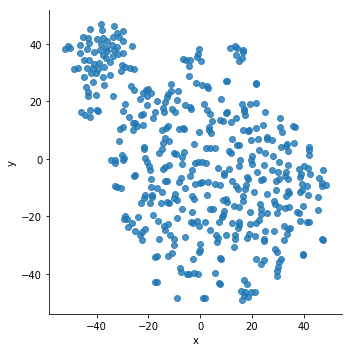

In [74]:
def test_vis(distance_matrix):
    X_embedded = TSNE(n_iter = 1000,
                      early_exaggeration = 10,
                      learning_rate = 900, 
                      method = "exact", 
                      metric = "precomputed").fit_transform(distance_matrix+0.000001)
    #X_embedded = decomposition.PCA(n_components=2).fit_transform(vecs)
    df = pd.DataFrame(X_embedded)
    #print(len(X_embedded))
    #df['label'] = sc.labels_
    df.columns = ['x', 'y']
    sns.lmplot(x="x", y="y",  data=df, fit_reg=False)
    plt.show()
test_vis(distance_matrix)

In [292]:
class PuncSplitTokenizer():
    """
        Map punctuations to space and then split, optional to remove predefined stopwords
    """
    def __init__(self, stopwords):
        __init__(self)
        self.stopwords = stopwords
    
    def __init__(self):
        self.translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
        self.stopwords = []
        
    def tokenize(self, text):
        tokens = text.translate(self.translator).lower().split()
        if self.stopwords:
            tokens = [t for t in tokens if t not in self.stopwords]
        return tokens

class TopicClusterGadget():
    """
        For vectorizing and computing document distance, based on word-topic-clusters in a document. 
        Implemented wmd_cosine, wmd_euclidean, and soft_cosine
    """
    def __init__(self, tokenizer, cls, distance_measure, word2vec, fixed_num_clusters):
        self.cls = cls
        self.tokenizer = tokenizer
        self.word2vec = word2vec
        self.distance_measure = distance_measure 
        self.fixed_num_clusters = fixed_num_clusters
        self.name = "{}+{}".format(cls, distance_measure)
        self.topics = []
        if distance_measure == "wmd_euclidean":
            self.get_distance = DistanceTool().wmd_distance_euclidean
        elif distance_measure == "wmd_cosine":
            self.get_distance = DistanceTool().wmd_distance_cosine
        elif self.distance_measure == "soft_cosine":
            self.get_distance = DistanceTool().softcosine_distance
        
    
    def tokenize(self, text):
        return self.tokenizer(text)
    
    def vectorize_all(self, train_X, test_X):
        train_vecs = [self.encode(t) for t in train_X]
        test_vecs = [self.encode(t) for t in test_X]
        max_len = np.max(np.concatenate(([len(a) for a in train_vecs], [len(a) for a in test_vecs])))
        train_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in train_vecs])
        test_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in test_vecs])
        return train_vecs, test_vecs
        
    def encode(self, text):
        text = self.tokenize(text)
        text = [t for t in text if t in self.word2vec]
        word_counter = Counter(text)
        word_counts = np.array(list(word_counter.values()))
        unique_text = np.array(list(word_counter.keys()))
        vecs = np.array([self.word2vec[w] for w in unique_text])
        num_clusters = math.floor(np.cbrt(len(unique_text))) if self.fixed_num_clusters <0 else self.fixed_num_clusters
                                
        if self.cls == "k-means": 
            model = KMeans(n_clusters = num_clusters, random_state=3425, precompute_distances = True)
            model.fit(vecs)
            distance_matrix = euclidean_distances(vecs)
            cluster_centers = model.cluster_centers_
            labels = model.labels_
        elif self.cls == "dsc":
            model = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=2)
            similarity_matrix = cosine_similarity(vecs).clip(0,1) 
            model.fit(similarity_matrix) 
            distance_matrix = 1-similarity_matrix
            labels = model.labels_
        elif self.cls == "random":
            labels = np.array(random.choices(range(num_clusters), k = len(vecs)))
        non_empty_clusters = np.array(list(set(labels))) 
        
        indices = [np.where(labels == i) if i in non_empty_clusters 
                                                           else [] for i in range(num_clusters)]
        
        if self.cls in ["dsc", "random"]:
            cluster_centers = np.array([np.mean(vecs[indices[i]], axis = 0) for i in non_empty_clusters])
        
        #sizes = np.array([sum(word_counts[indices[i]]) for i in non_empty_clusters])
        weights = [(sum(importance_vecs(vecs[indices[i]]))/len(indices[i][0]))
                   *np.log2(sum(word_counts[indices[i]])) for i in non_empty_clusters]
        weights = weights/sum(weights)
        return np.concatenate([[len(non_empty_clusters)], cluster_centers.flatten(), weights])
    
    def decode(self, a, b):
        num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
        cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
        topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
        weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
        allTopics = np.concatenate([topics1,topics2])
        d1 = np.concatenate([weights1,[0]*len(topics2)])
        d2 = np.concatenate([[0]*len(topics1),weights2])
        return d1, d2, allTopics

class DistanceTool():
    """
        Implemented wmd_cosine, wmd_euclidean, and soft_cosine
    """
    def decode(self, a, b):
        num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
        cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
        topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
        weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
        allTopics = np.concatenate([topics1,topics2])
        d1 = np.concatenate([weights1,[0]*len(topics2)])
        d2 = np.concatenate([[0]*len(topics1),weights2])
        return d1, d2, allTopics
    
    def softcosine_distance(self, vec1, vec2):
        d1, d2, allTopics = self.decode(vec1, vec2)
        similarity_matrix = cosine_similarity(allTopics).clip(0,1)
        base1 = d1.dot(similarity_matrix)
        result = base1.dot(d2)
        vec1 = base1.dot(d1)
        vec2 = d2.dot(similarity_matrix).dot(d2)
        result /= (np.sqrt(vec1)*np.sqrt(vec2))
        return 1-result
    
    def hausdorff_distance(self, vec1, vec2):
        num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
        cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
        topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
        weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
        
    def wmd_distance_euclidean(self, vec1, vec2):
        return self.wmd_distance(vec1, vec2, euclidean_distances)
    
    def wmd_distance_cosine(self, vec1, vec2):
        return self.wmd_distance(vec1, vec2, cosine_distances)
    
    def wmd_distance(self, vec1, vec2, distance_func):
        d1, d2, allTopics = self.decode(vec1, vec2)
        distance_matrix = distance_func(allTopics, allTopics)
        return emd(d1, d2, distance_matrix)

class WordAverageGadget():
    """
        Averaging word vectors method
    """
    def __init__(self, tokenizer, word2vec, weighting):
        self.word2vec = word2vec
        self.tokenizer = tokenizer
        self.cls = "average"
        self.distance_measure = "word_average"
        self.weighting = weighting
        
    def tokenize(self, text):
        return self.tokenizer(text)
    
    def vectorize_all(self, train_X, test_X):
        train_X = [self.encode(t) for t in train_X]
        test_X = [self.encode(t) for t in test_X]
        return train_X, test_X
    
    def encode(self, text):
        text = self.tokenize(text)
        if self.weighting:
            vecs = np.array([self.word2vec[word] for word in text if word in self.word2vec])
            importances = importance_vecs(vecs)
            weighted_vecs = [v*i for v, i in zip(vecs, importances)]
            return np.mean(weighted_vecs, axis = 0)
        else:
            vecs = [self.word2vec[w] for w in text if w in self.word2vec]
            return np.mean(vecs, axis=0)
    
    def decode(self):
        pass
        
class WordMoversDistanceGadget():
    """
        The original word mover's distance
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.cls = "none"
        self.distance_measure = "wmd"
        
    def tokenize(self, text):
        pass
    
    def vectorize_all(self, train_X, test_X):
        vec_all = CountVectorizer(stop_words="english").fit(train_X + test_X)
        common = [word for word in vec_all.get_feature_names() if word in self.word2vec]
        self.word2vec_common = [self.word2vec[t] for t in common]
        vect = CountVectorizer(vocabulary=common, dtype=np.double)
        train_X = normalize(vect.fit_transform(train_X), norm = 'l1', copy = False)
        test_X = normalize(vect.transform(test_X), norm = 'l1', copy = False)
        return train_X, test_X
    
    def get_distance(self, vec1, vec2):
        indices = np.union1d(vec1.indices, vec2.indices)
        vecs = [self.word2vec_common[i] for i in indices]
        distance_matrix = euclidean_distances(vecs)
        d1 = vec1[indices]
        d2 = vec2[indices]
        return emd(d1, d2, distance_matrix)
    
    def get_distance_matrix(self, train_vecs, test_vecs):
        #dist = [[self.get_distance(i, j)] for i, j in test_vecs, train_vecs]
        #dist = np.array([self.get_distance(i, j) for u, v in test_vecs, train_vecs])
        #dist = dist.reshape(len(test_vecs), -1)
        #dist = Parallel(n_jobs=1)(
         #   delayed(self.get_distance)(test_sample, train_vecs)
          #  for test_sample in test_vecs)
        return dist
    def encode(self):
        pass
    
    def decode(self):
        pass



# Benchmarking

In [218]:

def mix_bbcnews(topics, mixed_groups, BBC):
    #bbcnews: 2225
    print("mixing bbc news")
    min_size = min([len(BBC[topic]) for topic in topics])
    size = int(min_size/len(mixed_groups))
    print("#total samples: {}".format(len(BBC.data)))
    print("#samples per label: {}".format(size))
    BBC_mixed = MyDataContainer({'data': [],
               'target': [],
               'topics': []})
    for i, topic_group in enumerate(mixed_groups):    
        for j in range(size):
            #document_samples = [BBCNews.data[random.choice(BBCNews[topic])] for topic in topic_group]
            document_samples = [BBC.data[BBC[topic][int(i*size+j)]] for topic in topic_group]
            new_document = " ".join(document_samples)
            BBC_mixed.data.append(new_document)
            BBC_mixed.target.append(i)
            BBC_mixed.topics.append(topic_group)
        print("label: {}, topics: {}".format(i, topic_group))
    print("{} records loaded".format(len(BBC_mixed.data)))
    return BBC_mixed

def mix_news20(topics, mixed_ids, mixed_group):
    print("mixing 20 news")
    news20_all = fetch_20newsgroups(categories=topics)
    data_labels = [fetch_20newsgroups(categories=[topic]).data for topic in topics]
    min_size = min([len(data) for data in data_labels])
    #lens = [len(data) for data.data in data_labels]
    size = int(min_size/len(mixed_groups))
    print("#total samples:{}".format(len(news20_all.data)))
    print("#samples per label:{}".format(size))
    
    news20_mixed = MyDataContainer({'data': [],
               'target': [],
               'topics': []})
    for i, topicid_group in enumerate(mixed_ids):
        #group_samples = [fetch_20newsgroups(categories=[topic]) for topic in topic_group]
        
        for j in range(size):
            document_samples = [data_labels[iid][i*size+j] for iid in topicid_group]
            new_document = " ".join(document_samples)
            news20_mixed.data.append(new_document)
            news20_mixed.target.append(i)
            news20_mixed.topics.append(mixed_group[i])
        print("label: {}, topics: {}".format(i, mixed_group[i]))
    print("{} records loaded".format(len(news20_mixed.data)))
    return news20_all, news20_mixed
names_datasets = ["BBCSport_4", "BBCNews_4", "BBCNews_3", "BBCNews_2", "Newsgroup_4"]
topics_bbcsport = ["athletics", "cricket","football","rugby","tennis"]
topics = [topics_bbcsport[i] for i in [0,1,2,3,4]]
mixed_ids = [[0,1,2],
             [0,1,3],
             [0,2,3],
             [1,2,3]]
mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]
BBCSport_mixed1 = mix_bbcnews(topics, mixed_groups, BBCSport)

topics_bbcnews = ["business", "entertainment", "politics", "sport", "tech"]    
topics = [topics_bbcnews[i] for i in [0,1,2,3,4]]
mixed_ids = [[0,1,2,3],
             [0,1,2,4],
             [0,1,3,4],
             [0,2,3,4],
             [1,2,3,4]]
mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]
BBCNews_mixed1 = mix_bbcnews(topics, mixed_groups, BBCNews)

topics = [topics_bbcnews[i] for i in [1,2,3,4]]
mixed_ids = [[0,1,2],
             [0,1,3],
             [0,2,3],
             [1,2,3]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

BBCNews_mixed2 = mix_bbcnews(topics, mixed_groups, BBCNews)

topics = [topics_bbcnews[i] for i in [0,1,4]]
mixed_ids = [[0,1],
             [0,2],
             [1,2]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

BBCNews_mixed3 = mix_bbcnews(topics, mixed_groups, BBCNews)

topics_news20 = ['comp.sys.ibm.pc.hardware', 
              'rec.autos',
              'sci.space',
              'rec.sport.baseball',
              'sci.crypt',
              'talk.politics.guns']

topics = topics_news20

mixed_ids = [[0,1,2],
             [0,1,3],
             [0,2,3],
             [1,2,3]]

mixed_groups = [ [topics[id] for id in ids] for ids in mixed_ids ]

news20_all, news20_mixed = mix_news20(topics, mixed_ids, mixed_groups)

mixing bbc news
#total samples: 737
#samples per label: 25
label: 0, topics: ['athletics', 'cricket', 'football']
label: 1, topics: ['athletics', 'cricket', 'rugby']
label: 2, topics: ['athletics', 'football', 'rugby']
label: 3, topics: ['cricket', 'football', 'rugby']
100 records loaded
mixing bbc news
#total samples: 2225
#samples per label: 77
label: 0, topics: ['business', 'entertainment', 'politics', 'sport']
label: 1, topics: ['business', 'entertainment', 'politics', 'tech']
label: 2, topics: ['business', 'entertainment', 'sport', 'tech']
label: 3, topics: ['business', 'politics', 'sport', 'tech']
label: 4, topics: ['entertainment', 'politics', 'sport', 'tech']
385 records loaded
mixing bbc news
#total samples: 2225
#samples per label: 96
label: 0, topics: ['entertainment', 'politics', 'sport']
label: 1, topics: ['entertainment', 'politics', 'tech']
label: 2, topics: ['entertainment', 'sport', 'tech']
label: 3, topics: ['politics', 'sport', 'tech']
384 records loaded
mixing bbc n

In [843]:

def create_subset(data, k):
    subset = MyDataContainer({'data': [],
               'target': [],
               'topics': []})
    for i in range(len(set(data.target))):
        targets = np.array(data.target)
        ids = np.where(targets == i)[0]
        sample_ids = random.choices(ids, k = k)
        print(sample_ids)
        sample_docs = [data.data[j] for j in sample_ids]
        subset.data.extend(sample_docs)
        subset.target.extend([i]*k)
        
        subset.topics.extend([data.topics[sample_ids[0]]]*k)
    return subset
BBCNews_mixed_sample = create_subset(BBCNews_mixed1, 10)
print(BBCNews_mixed1.topics[0])
print(len(BBCNews_mixed_sample.data))

[3, 31, 40, 61, 51, 87, 53, 48, 6, 17]
[100, 179, 185, 122, 175, 159, 179, 184, 108, 126]
[222, 212, 194, 255, 257, 201, 206, 229, 278, 235]
[330, 360, 366, 364, 328, 297, 332, 365, 374, 292]
['business', 'entertainment', 'politics']
40


In [ ]:
word_dic = word2vec
datasets = [BBCNews]

stopwords_tokenizer = CountVectorizer(stop_words = "english").build_analyzer()
nostopwords_tokenizer = CountVectorizer().build_analyzer()
remove_stopwords = True
if remove_stopwords:
    tokenizerx = nostopwords_tokenizer
else:
    tokenizerx = nostopwords_tokenizer

#models = [WordMoversDistanceGadget(word_dic)]

mystopwords = "english" if remove_stopwords else None

bowVectorizer = make_pipeline(CountVectorizer(stop_words = mystopwords), 
                              Normalizer(norm = 'l1', copy = False)) 

tfidfVectorizer = make_pipeline(TfidfVectorizer(stop_words = mystopwords,use_idf = True),
                               Normalizer(norm = 'l1', copy = False))

BLmodels = [[bowVectorizer], [tfidfVectorizer]]

LDAmodels = [[make_pipeline(CountVectorizer(stop_words = mystopwords)
                              ,lda.LDA(n_topics=i, n_iter=100)) for i in range(10,40,2)]]

LSImodels = [[make_pipeline(CountVectorizer(stop_words = mystopwords), 
                                 Normalizer(norm = 'l1', copy = False), 
                                 TruncatedSVD(i)) for i in range(50,400,30)]]
WCDmodels = [WordAverageGadget(tokenizerx, word_dic, False),
            WordAverageGadget(tokenizerx, word_dic, True)]
n_k = 4
KMmodels = [[TopicClusterGadget(tokenizerx, "k-means", "wmd_euclidean", word_dic,n_k),
          #TopicClusterGadget(tokenizerx, "k-means", "wmd_cosine", word_dic,n_k),
          TopicClusterGadget(tokenizerx, "k-means", "soft_cosine", word_dic,n_k)]]

DSCmodels = [[TopicClusterGadget(tokenizerx, "dsc", "wmd_euclidean", word_dic,n_k),
              #TopicClusterGadget(tokenizerx, "dsc", "wmd_cosine", word_dic,n_k),
              TopicClusterGadget(tokenizerx, "dsc", "soft_cosine", word_dic,n_k)]]
classicals = ["BOW", "TF-IDF", "LSI", "LDA"]
WCDs = ["WCD", "WCD_I"]
KMs = ["kmeans_wmd_euclidean", "kmeans_soft_cosine"]
DSCs = ["dsc_wmd", "dsc_soft_cosine"]

k_values = range(10,35,5)
results_per_dataset=[]

for ds in datasets:
    accuracies = []
    train_X, test_X, train_y, test_y = train_test_split(ds.data, ds.target, test_size=0.4, 
                                                        shuffle = True, stratify = ds.target, random_state=42)
    
    cont_X, valid_X, cont_y, valid_y = train_test_split(train_X, train_y, test_size = 0.2, 
                                                        shuffle = True, random_state = 42, stratify = train_y)
    print("Training size:{}\n Test size:{}".format(len(train_X), len(test_X)))
    print("#Label: {}".format(len(set(train_y))))
    
    #print("Evaluating classical models...")
    for k in k_values: 
        k_accuracies = []
        
        print("fitting KNN for k = {}".format(k))
        for i, models in enumerate(BLmodels+LSImodels+LDAmodels): 
            print("fitting {}".format(classicals[i]))
            model_classification_reports = []
            max_accuracy = 0
            
            best_model = None
            max_accuracy = 0
            for model in models:
                cont_vecs = model.fit_transform(list(cont_X)+list(valid_X))
                valid_vecs = model.transform(valid_X)
                nbrs = KNeighborsClassifier(algorithm='brute', metric = "cosine", n_neighbors = k)
                nbrs.fit(cont_vecs, cont_y)
                prediction = nbrs.predict(valid_vecs)
                acc = accuracy_score(prediction, valid_y)
                if max_accuracy < acc:
                    print("find better")
                    best_model = model
                    best_tree = nbrs
                max_accuracy = acc
                #model_classification_reports.append(classification_report(test_y, prediction))
                #classification_reports.append(model_classification_reports)
            best_model.fit(list(train_X)+list(test_X))
            train_vecs = best_model.transform(train_X)
            test_vecs = best_model.transform(test_X)
            best_tree.fit(train_vecs, train_y)
            prediction = best_tree.predict(test_vecs)
            acc = accuracy_score(prediction, test_y)
            print("accuracy: {}".format(acc))
            k_accuracies.append(acc)   
        
        for model in WCDmodels:
            for metric in ["cosine"]:
                print("fitting WCD {}".format(metric))
                train_vecs, test_vecs = model.vectorize_all(train_X, test_X)
                nbrs = KNeighborsClassifier(algorithm='brute', metric = metric, n_neighbors = k)
                nbrs.fit(train_vecs, train_y)
                print("predicting")
                prediction = nbrs.predict(test_vecs)
                acc = accuracy_score(prediction, test_y)
                print("accuracy: {}".format(acc))
                k_accuracies.append(acc)

        for names, models in zip([DSCs],DSCmodels):
            start = time.time()
            print("fitting {}".format(models[0].cls))
            train_vecs, test_vecs = models[0].vectorize_all(train_X, test_X)
            print("{}s for vectorization".format(time.time() - start))
            for i, model in enumerate(models):
                print("predicting {}".format(names[i]))
                start = time.time()
                nbrs = KNeighborsClassifier(algorithm='ball_tree', n_neighbors = k,
                                    metric=lambda a,b: model.get_distance(a, b))
                nbrs.fit(train_vecs, train_y)
                prediction = nbrs.predict(test_vecs)
                acc = accuracy_score(prediction, test_y)
                print("{}s for predicting".format(time.time()-start))
                print("accuracy: {}".format(acc))
                k_accuracies.append(acc)
        accuracies.append(k_accuracies)
    results_per_dataset.append(accuracies)
                

Training size:1335
 Test size:890
#Label: 5
fitting KNN for k = 10
fitting BOW
find better
accuracy: 0.9292134831460674
fitting TF-IDF
find better
accuracy: 0.9415730337078652
fitting LSI
find better
find better
find better
find better
accuracy: 0.9370786516853933
fitting LDA


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 10
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2688315
INFO:lda:<10> log likelihood: -2126634
INFO:lda:<20> log likelihood: -2052611
INFO:lda:<30> log likelihood: -2025172
INFO:lda:<40> log likelihood: -2011344
INFO:lda:<50> log likelihood: -2001014
INFO:lda:<60> log likelihood: -1995311
INFO:lda:<70> log likelihood: -1989831
INFO:lda:<80> log likelihood: -1986525
INFO:lda:<90> log likelihood: -1983305
INFO:lda:<99> log likelihood: -1980946


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 12
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2747189
INFO:lda:<10> log likelihood: -2128198
INFO:lda:<20> log likelihood: -2054899
INFO:lda:<30> log likelihood: -2027380
INFO:lda:<40> log likelihood: -2011137
INFO:lda:<50> log likelihood: -2003107
INFO:lda:<60> log likelihood: -1996154
INFO:lda:<70> log likelihood: -1991866
INFO:lda:<80> log likelihood: -1987552
INFO:lda:<90> log likelihood: -1984667
INFO:lda:<99> log likelihood: -1981967


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 14
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2798316
INFO:lda:<10> log likelihood: -2140789
INFO:lda:<20> log likelihood: -2061303
INFO:lda:<30> log likelihood: -2031516
INFO:lda:<40> log likelihood: -2014684
INFO:lda:<50> log likelihood: -2003199
INFO:lda:<60> log likelihood: -1994704
INFO:lda:<70> log likelihood: -1989430
INFO:lda:<80> log likelihood: -1985116
INFO:lda:<90> log likelihood: -1981350
INFO:lda:<99> log likelihood: -1977791


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 16
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2841458
INFO:lda:<10> log likelihood: -2142800
INFO:lda:<20> log likelihood: -2067791
INFO:lda:<30> log likelihood: -2040075
INFO:lda:<40> log likelihood: -2022955
INFO:lda:<50> log likelihood: -2010980
INFO:lda:<60> log likelihood: -2003257
INFO:lda:<70> log likelihood: -1995826
INFO:lda:<80> log likelihood: -1990984
INFO:lda:<90> log likelihood: -1987096
INFO:lda:<99> log likelihood: -1983562
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 18
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2880654
INFO:lda:<10> log likelihood: -2129541
INFO:lda:<20> log likelihood: -2052712
INFO:lda:<30> log likelihood: -2023117
INFO:lda:<40> log likelihood: -2007750
INFO:lda:<50> log likelihood: -1998112
INFO:lda:<60> log likelihood: -1991584
INFO:lda:<70> log likelihood: -1986354
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 22
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2948518
INFO:lda:<10> log likelihood: -2150928
INFO:lda:<20> log likelihood: -2069514
INFO:lda:<30> log likelihood: -2037854
INFO:lda:<40> log likelihood: -2018608
INFO:lda:<50> log likelihood: -2007386
INFO:lda:<60> log likelihood: -1999756
INFO:lda:<70> log likelihood: -1993794
INFO:lda:<80> log likelihood: -1989568
INFO:lda:<90> log likelihood: -1985259
INFO:lda:<99> log likelihood: -1982216
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 24
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2979473
INFO:lda:<10> log likelihood: -2148008
INFO:lda:<20> log likelihood: -2067644
INFO:lda:<30> log likelihood: -2035484
INFO:lda:<40> log likelihood: -2017946
INFO:lda:<50> log likelihood: -2007681
INFO:lda:<60> log likelihood: -2000535
INFO:lda:<70> log likelihood: -1994453
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 28
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3031991
INFO:lda:<10> log likelihood: -2148828
INFO:lda:<20> log likelihood: -2068300
INFO:lda:<30> log likelihood: -2037563
INFO:lda:<40> log likelihood: -2017581
INFO:lda:<50> log likelihood: -2005253
INFO:lda:<60> log likelihood: -1998403
INFO:lda:<70> log likelihood: -1991511
INFO:lda:<80> log likelihood: -1985778
INFO:lda:<90> log likelihood: -1983074
INFO:lda:<99> log likelihood: -1979808
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 30
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3055270
INFO:lda:<10> log likelihood: -2144502
INFO:lda:<20> log likelihood: -2063159
INFO:lda:<30> log likelihood: -2033279
INFO:lda:<40> log likelihood: -2015907
INFO:lda:<50> log likelihood: -2005357
INFO:lda:<60> log likelihood: -1996945
INFO:lda:<70> log likelihood: -1991530
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 36
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3119645
INFO:lda:<10> log likelihood: -2154331
INFO:lda:<20> log likelihood: -2067056
INFO:lda:<30> log likelihood: -2032958
INFO:lda:<40> log likelihood: -2015303
INFO:lda:<50> log likelihood: -2004104
INFO:lda:<60> log likelihood: -1996715
INFO:lda:<70> log likelihood: -1990915
INFO:lda:<80> log likelihood: -1984734
INFO:lda:<90> log likelihood: -1982615
INFO:lda:<99> log likelihood: -1979221
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3138557
INFO:lda:<10> log likelihood: -2152351
INFO:lda:<20> log likelihood: -2069437
INFO:lda:<30> log likelihood: -2036765
INFO:lda:<40> log likelihood: -2019217
INFO:lda:<50> log likelihood: -2007251
INFO:lda:<60> log likelihood: -1999949
INFO:lda:<70> log likelihood: -1992781
INFO:lda:<80> log

find better


INFO:lda:n_documents: 2225
INFO:lda:vocab_size: 29126
INFO:lda:n_words: 456542
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -6350942
INFO:lda:<10> log likelihood: -4401717
INFO:lda:<20> log likelihood: -4207813
INFO:lda:<30> log likelihood: -4138145
INFO:lda:<40> log likelihood: -4099915
INFO:lda:<50> log likelihood: -4074902
INFO:lda:<60> log likelihood: -4054982
INFO:lda:<70> log likelihood: -4041426
INFO:lda:<80> log likelihood: -4030541
INFO:lda:<90> log likelihood: -4020613
INFO:lda:<99> log likelihood: -4015645


accuracy: 0.9415730337078652
fitting WCD cosine
predicting
accuracy: 0.9573033707865168
fitting WCD cosine
predicting
accuracy: 0.9483146067415731
fitting dsc
34.44359612464905s for vectorization
predicting dsc_wmd
283.3436939716339s for predicting
accuracy: 0.9056179775280899
predicting dsc_soft_cosine
173.59346890449524s for predicting
accuracy: 0.9415730337078652
fitting KNN for k = 15
fitting BOW
find better
accuracy: 0.9179775280898876
fitting TF-IDF
find better
accuracy: 0.9449438202247191
fitting LSI
find better
find better
find better
find better
find better
accuracy: 0.9370786516853933
fitting LDA


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 10
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2688315
INFO:lda:<10> log likelihood: -2134277
INFO:lda:<20> log likelihood: -2065836
INFO:lda:<30> log likelihood: -2039801
INFO:lda:<40> log likelihood: -2026563
INFO:lda:<50> log likelihood: -2017040
INFO:lda:<60> log likelihood: -2009829
INFO:lda:<70> log likelihood: -2003675
INFO:lda:<80> log likelihood: -1998371
INFO:lda:<90> log likelihood: -1993135
INFO:lda:<99> log likelihood: -1990283


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 12
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2747189
INFO:lda:<10> log likelihood: -2122713
INFO:lda:<20> log likelihood: -2053272
INFO:lda:<30> log likelihood: -2024663
INFO:lda:<40> log likelihood: -2009554
INFO:lda:<50> log likelihood: -2000919
INFO:lda:<60> log likelihood: -1992217
INFO:lda:<70> log likelihood: -1986579
INFO:lda:<80> log likelihood: -1982187
INFO:lda:<90> log likelihood: -1979504
INFO:lda:<99> log likelihood: -1976476


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 14
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2798316
INFO:lda:<10> log likelihood: -2138078
INFO:lda:<20> log likelihood: -2059761
INFO:lda:<30> log likelihood: -2029477
INFO:lda:<40> log likelihood: -2012395
INFO:lda:<50> log likelihood: -2001551
INFO:lda:<60> log likelihood: -1993911
INFO:lda:<70> log likelihood: -1987982
INFO:lda:<80> log likelihood: -1984483
INFO:lda:<90> log likelihood: -1981015
INFO:lda:<99> log likelihood: -1978105


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 16
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2841458
INFO:lda:<10> log likelihood: -2132782
INFO:lda:<20> log likelihood: -2054570
INFO:lda:<30> log likelihood: -2025479
INFO:lda:<40> log likelihood: -2009305
INFO:lda:<50> log likelihood: -2000056
INFO:lda:<60> log likelihood: -1993172
INFO:lda:<70> log likelihood: -1988836
INFO:lda:<80> log likelihood: -1983552
INFO:lda:<90> log likelihood: -1980856
INFO:lda:<99> log likelihood: -1977970
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 18
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2880654
INFO:lda:<10> log likelihood: -2140149
INFO:lda:<20> log likelihood: -2061878
INFO:lda:<30> log likelihood: -2029878
INFO:lda:<40> log likelihood: -2012053
INFO:lda:<50> log likelihood: -2000840
INFO:lda:<60> log likelihood: -1990821
INFO:lda:<70> log likelihood: -1984630
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 20
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2916498
INFO:lda:<10> log likelihood: -2139703
INFO:lda:<20> log likelihood: -2061343
INFO:lda:<30> log likelihood: -2030140
INFO:lda:<40> log likelihood: -2014302
INFO:lda:<50> log likelihood: -2003371
INFO:lda:<60> log likelihood: -1996634
INFO:lda:<70> log likelihood: -1989661
INFO:lda:<80> log likelihood: -1985075
INFO:lda:<90> log likelihood: -1980948
INFO:lda:<99> log likelihood: -1976546
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 22
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2948518
INFO:lda:<10> log likelihood: -2143512
INFO:lda:<20> log likelihood: -2066738
INFO:lda:<30> log likelihood: -2036257
INFO:lda:<40> log likelihood: -2019984
INFO:lda:<50> log likelihood: -2007230
INFO:lda:<60> log likelihood: -1998058
INFO:lda:<70> log likelihood: -1992418
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 24
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2979473
INFO:lda:<10> log likelihood: -2139854
INFO:lda:<20> log likelihood: -2061331
INFO:lda:<30> log likelihood: -2031557
INFO:lda:<40> log likelihood: -2014540
INFO:lda:<50> log likelihood: -2003609
INFO:lda:<60> log likelihood: -1995399
INFO:lda:<70> log likelihood: -1989465
INFO:lda:<80> log likelihood: -1983547
INFO:lda:<90> log likelihood: -1980088
INFO:lda:<99> log likelihood: -1976933
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 26
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3006438
INFO:lda:<10> log likelihood: -2148755
INFO:lda:<20> log likelihood: -2064685
INFO:lda:<30> log likelihood: -2033884
INFO:lda:<40> log likelihood: -2016389
INFO:lda:<50> log likelihood: -2004683
INFO:lda:<60> log likelihood: -1996300
INFO:lda:<70> log likelihood: -1990428
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 28
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3031991
INFO:lda:<10> log likelihood: -2155101
INFO:lda:<20> log likelihood: -2070300
INFO:lda:<30> log likelihood: -2036721
INFO:lda:<40> log likelihood: -2019654
INFO:lda:<50> log likelihood: -2008463
INFO:lda:<60> log likelihood: -1999701
INFO:lda:<70> log likelihood: -1993000
INFO:lda:<80> log likelihood: -1988991
INFO:lda:<90> log likelihood: -1984135
INFO:lda:<99> log likelihood: -1980717
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 30
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3055270
INFO:lda:<10> log likelihood: -2148161
INFO:lda:<20> log likelihood: -2065374
INFO:lda:<30> log likelihood: -2032761
INFO:lda:<40> log likelihood: -2017977
INFO:lda:<50> log likelihood: -2005208
INFO:lda:<60> log likelihood: -1996740
INFO:lda:<70> log likelihood: -1990795
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 36
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3119645
INFO:lda:<10> log likelihood: -2155074
INFO:lda:<20> log likelihood: -2067218
INFO:lda:<30> log likelihood: -2035667
INFO:lda:<40> log likelihood: -2019200
INFO:lda:<50> log likelihood: -2008049
INFO:lda:<60> log likelihood: -1999676
INFO:lda:<70> log likelihood: -1993335
INFO:lda:<80> log likelihood: -1989855
INFO:lda:<90> log likelihood: -1985879
INFO:lda:<99> log likelihood: -1981768


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3138557
INFO:lda:<10> log likelihood: -2155591
INFO:lda:<20> log likelihood: -2070420
INFO:lda:<30> log likelihood: -2035939
INFO:lda:<40> log likelihood: -2018789
INFO:lda:<50> log likelihood: -2006927
INFO:lda:<60> log likelihood: -1998436
INFO:lda:<70> log likelihood: -1992970
INFO:lda:<80> log likelihood: -1987151
INFO:lda:<90> log likelihood: -1983978
INFO:lda:<99> log likelihood: -1978881


find better


INFO:lda:n_documents: 2225
INFO:lda:vocab_size: 29126
INFO:lda:n_words: 456542
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -6350942
INFO:lda:<10> log likelihood: -4406295
INFO:lda:<20> log likelihood: -4206237
INFO:lda:<30> log likelihood: -4136406
INFO:lda:<40> log likelihood: -4099465
INFO:lda:<50> log likelihood: -4074165
INFO:lda:<60> log likelihood: -4057442
INFO:lda:<70> log likelihood: -4044515
INFO:lda:<80> log likelihood: -4036909
INFO:lda:<90> log likelihood: -4028834
INFO:lda:<99> log likelihood: -4021983


accuracy: 0.9280898876404494
fitting WCD cosine
predicting
accuracy: 0.9471910112359551
fitting WCD cosine
predicting
accuracy: 0.9415730337078652
fitting dsc
33.33958101272583s for vectorization
predicting dsc_wmd
287.9913568496704s for predicting
accuracy: 0.9
predicting dsc_soft_cosine
168.46614718437195s for predicting
accuracy: 0.9247191011235955
fitting KNN for k = 20
fitting BOW
find better
accuracy: 0.9157303370786517
fitting TF-IDF
find better
accuracy: 0.9404494382022472
fitting LSI
find better
find better
find better
find better
accuracy: 0.9382022471910112
fitting LDA


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 10
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2688315
INFO:lda:<10> log likelihood: -2131301
INFO:lda:<20> log likelihood: -2053492
INFO:lda:<30> log likelihood: -2025204
INFO:lda:<40> log likelihood: -2009363
INFO:lda:<50> log likelihood: -1997016
INFO:lda:<60> log likelihood: -1990069
INFO:lda:<70> log likelihood: -1985274
INFO:lda:<80> log likelihood: -1981397
INFO:lda:<90> log likelihood: -1979117
INFO:lda:<99> log likelihood: -1977668


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 12
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2747189
INFO:lda:<10> log likelihood: -2127289
INFO:lda:<20> log likelihood: -2052662
INFO:lda:<30> log likelihood: -2025141
INFO:lda:<40> log likelihood: -2010237
INFO:lda:<50> log likelihood: -1999369
INFO:lda:<60> log likelihood: -1992684
INFO:lda:<70> log likelihood: -1986730
INFO:lda:<80> log likelihood: -1982042
INFO:lda:<90> log likelihood: -1977568
INFO:lda:<99> log likelihood: -1974682
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 14
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2798316
INFO:lda:<10> log likelihood: -2145169
INFO:lda:<20> log likelihood: -2072991
INFO:lda:<30> log likelihood: -2039848
INFO:lda:<40> log likelihood: -2022606
INFO:lda:<50> log likelihood: -2009521
INFO:lda:<60> log likelihood: -2002125
INFO:lda:<70> log likelihood: -1995424
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 16
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2841458
INFO:lda:<10> log likelihood: -2134906
INFO:lda:<20> log likelihood: -2059001
INFO:lda:<30> log likelihood: -2029654
INFO:lda:<40> log likelihood: -2014198
INFO:lda:<50> log likelihood: -2004688
INFO:lda:<60> log likelihood: -1996439
INFO:lda:<70> log likelihood: -1991467
INFO:lda:<80> log likelihood: -1987714
INFO:lda:<90> log likelihood: -1984365
INFO:lda:<99> log likelihood: -1982142
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 18
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2880654
INFO:lda:<10> log likelihood: -2135833
INFO:lda:<20> log likelihood: -2061129
INFO:lda:<30> log likelihood: -2032248
INFO:lda:<40> log likelihood: -2014892
INFO:lda:<50> log likelihood: -2001960
INFO:lda:<60> log likelihood: -1995309
INFO:lda:<70> log likelihood: -1989244
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 20
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2916498
INFO:lda:<10> log likelihood: -2142646
INFO:lda:<20> log likelihood: -2060264
INFO:lda:<30> log likelihood: -2028545
INFO:lda:<40> log likelihood: -2009407
INFO:lda:<50> log likelihood: -1999369
INFO:lda:<60> log likelihood: -1990620
INFO:lda:<70> log likelihood: -1984794
INFO:lda:<80> log likelihood: -1980668
INFO:lda:<90> log likelihood: -1977505
INFO:lda:<99> log likelihood: -1974315
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 22
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2948518
INFO:lda:<10> log likelihood: -2141575
INFO:lda:<20> log likelihood: -2060601
INFO:lda:<30> log likelihood: -2031785
INFO:lda:<40> log likelihood: -2013866
INFO:lda:<50> log likelihood: -2002436
INFO:lda:<60> log likelihood: -1993259
INFO:lda:<70> log likelihood: -1986692
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 28
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3031991
INFO:lda:<10> log likelihood: -2152727
INFO:lda:<20> log likelihood: -2067440
INFO:lda:<30> log likelihood: -2035518
INFO:lda:<40> log likelihood: -2017682
INFO:lda:<50> log likelihood: -2006487
INFO:lda:<60> log likelihood: -1998839
INFO:lda:<70> log likelihood: -1992954
INFO:lda:<80> log likelihood: -1987749
INFO:lda:<90> log likelihood: -1983786
INFO:lda:<99> log likelihood: -1980573
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 30
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3055270
INFO:lda:<10> log likelihood: -2151435
INFO:lda:<20> log likelihood: -2065377
INFO:lda:<30> log likelihood: -2032719
INFO:lda:<40> log likelihood: -2015371
INFO:lda:<50> log likelihood: -2003457
INFO:lda:<60> log likelihood: -1994704
INFO:lda:<70> log likelihood: -1987986
INFO:lda:<80> log

find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 34
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3099746
INFO:lda:<10> log likelihood: -2149926
INFO:lda:<20> log likelihood: -2070779
INFO:lda:<30> log likelihood: -2039194
INFO:lda:<40> log likelihood: -2018590
INFO:lda:<50> log likelihood: -2008341
INFO:lda:<60> log likelihood: -2000295
INFO:lda:<70> log likelihood: -1992984
INFO:lda:<80> log likelihood: -1986249
INFO:lda:<90> log likelihood: -1982049
INFO:lda:<99> log likelihood: -1978179
INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 36
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -3119645
INFO:lda:<10> log likelihood: -2146377
INFO:lda:<20> log likelihood: -2065773
INFO:lda:<30> log likelihood: -2033257
INFO:lda:<40> log likelihood: -2015128
INFO:lda:<50> log likelihood: -2003387
INFO:lda:<60> log likelihood: -1995425
INFO:lda:<70> log likelihood: -1987616
INFO:lda:<80> log

find better


INFO:lda:n_documents: 2225
INFO:lda:vocab_size: 29126
INFO:lda:n_words: 456542
INFO:lda:n_topics: 38
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -6350942
INFO:lda:<10> log likelihood: -4392745
INFO:lda:<20> log likelihood: -4201967
INFO:lda:<30> log likelihood: -4132568
INFO:lda:<40> log likelihood: -4092650
INFO:lda:<50> log likelihood: -4068830
INFO:lda:<60> log likelihood: -4051505
INFO:lda:<70> log likelihood: -4038044
INFO:lda:<80> log likelihood: -4026524
INFO:lda:<90> log likelihood: -4017330
INFO:lda:<99> log likelihood: -4011654


accuracy: 0.9224719101123595
fitting WCD cosine
predicting
accuracy: 0.9404494382022472
fitting WCD cosine
predicting
accuracy: 0.9438202247191011
fitting dsc
35.44174790382385s for vectorization
predicting dsc_wmd
288.65308809280396s for predicting
accuracy: 0.8943820224719101
predicting dsc_soft_cosine
167.52418422698975s for predicting
accuracy: 0.9280898876404494
fitting KNN for k = 25
fitting BOW
find better
accuracy: 0.9089887640449438
fitting TF-IDF
find better
accuracy: 0.9438202247191011
fitting LSI
find better
find better
find better
find better
find better
accuracy: 0.9359550561797753
fitting LDA


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 10
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2688315
INFO:lda:<10> log likelihood: -2144501
INFO:lda:<20> log likelihood: -2065207
INFO:lda:<30> log likelihood: -2036753
INFO:lda:<40> log likelihood: -2020610
INFO:lda:<50> log likelihood: -2009289
INFO:lda:<60> log likelihood: -2002479
INFO:lda:<70> log likelihood: -1996710
INFO:lda:<80> log likelihood: -1992473
INFO:lda:<90> log likelihood: -1988419
INFO:lda:<99> log likelihood: -1985245


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 12
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2747189
INFO:lda:<10> log likelihood: -2135483
INFO:lda:<20> log likelihood: -2062233
INFO:lda:<30> log likelihood: -2034981
INFO:lda:<40> log likelihood: -2019495
INFO:lda:<50> log likelihood: -2008018
INFO:lda:<60> log likelihood: -2000882
INFO:lda:<70> log likelihood: -1993844
INFO:lda:<80> log likelihood: -1989404
INFO:lda:<90> log likelihood: -1986624
INFO:lda:<99> log likelihood: -1982399


find better


INFO:lda:n_documents: 1068
INFO:lda:vocab_size: 21652
INFO:lda:n_words: 222568
INFO:lda:n_topics: 14
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -2798316
INFO:lda:<10> log likelihood: -2139639
INFO:lda:<20> log likelihood: -2062617
INFO:lda:<30> log likelihood: -2031620
INFO:lda:<40> log likelihood: -2014539
INFO:lda:<50> log likelihood: -2003372
INFO:lda:<60> log likelihood: -1995442


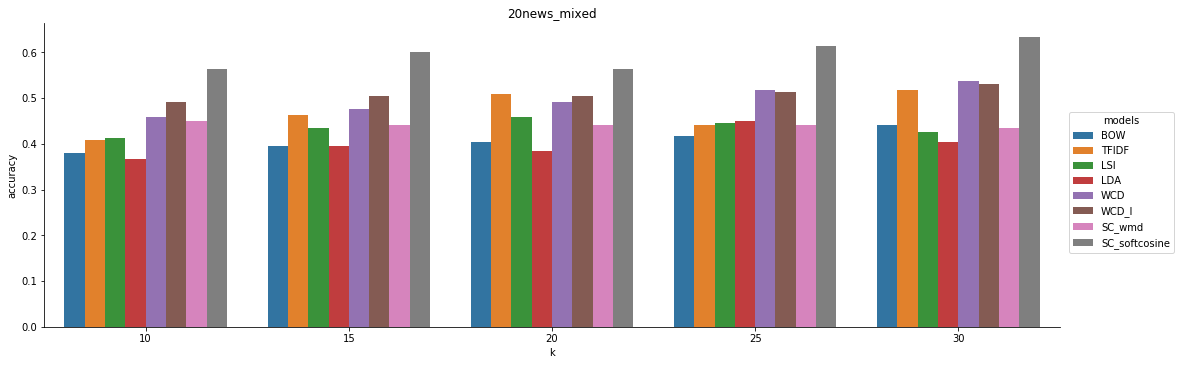

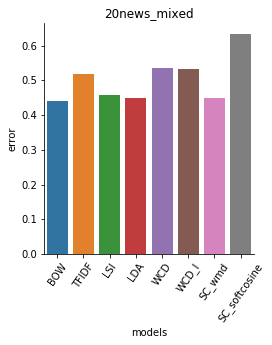

Help on function factorplot in module seaborn.categorical:

factorplot(x=None, y=None, hue=None, data=None, row=None, col=None, col_wrap=None, estimator=<function mean at 0x10b710ea0>, ci=95, n_boot=1000, units=None, order=None, hue_order=None, row_order=None, col_order=None, kind='point', size=4, aspect=1, orient=None, color=None, palette=None, legend=True, legend_out=True, sharex=True, sharey=True, margin_titles=False, facet_kws=None, **kwargs)
    Draw a categorical plot onto a FacetGrid.
    
    The default plot that is shown is a point plot, but other seaborn
    categorical plots can be chosen with the ``kind`` parameter, including
    box plots, violin plots, bar plots, or strip plots.
    
    It is important to choose how variables get mapped to the plot structure
    such that the most important comparisons are easiest to make. As a general
    rule, it is easier to compare positions that are closer together, so the
    ``hue`` variable should be used for the most important 

In [290]:
classicals = ["BOW", "TFIDF", "LSI", "LDA"]
WCDs = ["WCD", "WCD_I"]
#KMs = ["KM_wmd",  "KM_softcosine"]
DSCs = ["SC_wmd",  "SC_softcosine"]
#names_datasets = ["BBCNews", "BBCNews_4", "BBCNews_3", "BBCNews_2","BBCSport_4", "Newsgroup_4"]
names_datasets = ["20news_mixed"]
names = classicals+WCDs+DSCs

for i, results in enumerate(results_per_dataset):
    df_all = pd.DataFrame()
    for k, accuracy_per_k in zip(k_values, results):
        #max_accuracies = 1-np.amax(result, axis = 0)
        #max_accuracies = max_accuracies
        #accuracy = 1-np.array(accuracy_per_k)
        accuracy = accuracy_per_k
        #zipped = zip(accuracy, names)
        #sort =  sorted(zip(accuracy,names), reverse = True)
        #sort_err = [e for e,_ in sort]
        #sort_name = [n for _,n in sort]
        df = pd.DataFrame({"accuracy": accuracy, "models": names, "k":accuracy})
        df["k"] = [k]*len(accuracy)
        df_all = df_all.append(df)
    ax = sns.factorplot(x="k", y="accuracy", data=df_all, hue = "models", kind = "bar", size = 5, aspect = 3)
    plt.xticks(rotation=0)
    plt.title(names_datasets[i])
    plt.show()      
      
for i, result in enumerate(results_per_dataset):
    avg_acc =np.max(result, axis = 0)
    #zipped = zip(accuracy, names)
    #sort =  sorted(zip(avg_acc,names), reverse = True)
    #sort_err = [e for e,_ in sort]
    #sort_name = [n for _,n in sort]
    df = pd.DataFrame({"error": avg_acc, "models": names})
    ax = sns.factorplot(x="models", y="error", data=df, aspect = 1, kind = "bar" )
    plt.xticks(rotation=55)
    plt.title(names_datasets[i])
    plt.show()
help(sns.factorplot)
#for x in accuracies:
 #   print(x)
#for report in classification_reports:
 #   print(report[-1])
#for accuracy in accuraciesT:
 #   plt.bar(range(len(accuracy)), accuracy)
  #  plt.show()

In [4]:
#pickle.dump(results_per_dataset, open("benchmark1.pickle", "wb"))
results_saved =pickle.load(open("benchmark1.pickle", "rb"))

In [42]:
0.82726423902894486, 0.86554621848739499, 0.86274509803921573, 
0.83660130718954251, 0.88982259570494859, 0.7796451914098973, 0.83846872082166202
print(X_train[0].indices)
print(common)
print(X_train[3].indices)
0.91616766467065869

NameError: name 'X_train' is not defined

In [47]:
a = [1,2,3,4]
a[[1,2,3]]

TypeError: list indices must be integers or slices, not list

In [ ]:
def wad(text):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    text = text.translate(translator).lower().split()
    text = [t for t in text if not t in stopwords.words("english")]
    return np.mean([word2vec[w] for w in text if w in word2vec], axis=0)

def wordcount(text):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    text = text.translate(translator).lower().split()
    text = [t for t in text if t in word2vec]
    return len(list(set(text)))
def build_vec_auto(text, cls, strategy):
    """build vector represenetation of text
        cls: Clustering model
        strategy: used with spectral clustering 
            0: non-empy clusters, positive silhoutte scores, weighted average
            1: 
    """
    x = text
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space    
    text = text.translate(translator).lower().split()
    start = time.time()
    text = [t for t in text if t in word2vec and not t in stopwords.words("english")]
    if cls == "kmeans":
        num_clusters = math.ceil(np.sqrt(len(set(text))))
        vecs = [word2vec[w] for w in text]
        km = KMeans(n_clusters = num_clusters, random_state=3425, precompute_distances = True)
        km.fit(vecs)
        non_empty_clusters = np.array(list(set(km.labels_)))
        indices = [np.where(sc.labels_ == i) if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
        
        sizes = np.array([sum(word_counts[indices[i]]) for i in non_empty_clusters])
        sizes_weights = sizes/sum(sizes)
        cluster_sizes = np.array([len(np.where(km.labels_ == i)[0]) for i in range(num_clusters)])
        weights = cluster_sizes/sum(cluster_sizes)
        
        return np.concatenate([[num_clusters], km.cluster_centers_.flatten(), weights])
    elif cls == "spectral":
        if strategy == 0:
            word_counter = Counter(text)
            unique_text = list(word_counter.keys())
            word_counts = np.array(list(word_counter.values()))
            if len(unique_text) < 3:
                unique_text = unique_text*2
                word_counts = word_counts*2
            num_clusters = math.ceil(np.sqrt(len(unique_text)))
            vecs = np.array([word2vec[w] for w in unique_text])
            sc = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=100)
            similarity_matrix = cosine_similarity(vecs)+1
            sc.fit(similarity_matrix)
            silhoutte_scores = silhouette_samples(2-similarity_matrix, sc.labels_, metric = 'precomputed')
            non_empty_clusters = np.array(list(set(sc.labels_)))
            indices = [np.where(sc.labels_ == i) if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
            sh_means = np.array([np.mean(silhoutte_scores[indices[i]]) for i in non_empty_clusters])
            pos_sh_means_indices = np.where(sh_means > 0)
            sh_means = sh_means[pos_sh_means_indices]
            good_clusters = non_empty_clusters[pos_sh_means_indices]
            sh_weights = np.array(sh_means/sum(sh_means))
            
            sizes = np.array([sum(word_counts[indices[i]]) for i in good_clusters])
            sizes_weights = sizes/sum(sizes)
            p = 0.3
            weights = p*sh_weights+(1-p)*sizes_weights
            #print("{},{},{}".format(sum(sh_weights), sum(sizes_weights), sum(weights)))
            centroids = np.array([np.mean(vecs[indices[i]], axis = 0) for i in good_clusters])
            rep = np.concatenate(([len(good_clusters)], centroids.flatten(), sizes_weights))
            return rep
        elif strategy == 1:
            word_counter = Counter(text)
            unique_text = list(word_counter.keys())
            word_counts = list(word_counter.values())
            if len(unique_text) < 3:
                unique_text = unique_text*2
                word_counts = word_counts*2
            num_clusters = math.ceil(np.sqrt(len(unique_text)))
            vecs = [word2vec[w] for w in unique_text]
            sc = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=100)
            similarity_matrix = cosine_similarity(vecs)+1
            sc.fit(similarity_matrix)
            silhoutte_scores = silhouette_samples(2-similarity_matrix, sc.labels_, metric = 'precomputed')
            silhoutte_contribution = np.multiply(word_counts, silhoutte_scores)
            total_contribution = sum(silhoutte_contribution)
            non_empty_clusters = list(set(sc.labels_))
            indices = [np.where(sc.labels_ == i)[0].tolist() if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
            
            weights = np.array([sum(np.take(silhoutte_contribution, indices[i]))/total_contribution
                                                                        for i in non_empty_clusters])
            #print("{},{},{}".format(sum(sh_weights), sum(sizes_weights), sum(final_weights)))
            centroids = np.array([np.mean(np.take(vecs, indices[i], axis = 0), axis = 0) for i in non_empty_clusters])
            rep = np.concatenate([[len(non_empty_clusters)], centroids.flatten(), weights])
            #for i in range(len(weights)):
             #   print(weights[i])
              #  print(np.take(unique_text, indices[non_empty_clusters[i]]))
            #print("-----")
            return rep
        elif strategy == 2:
            word_counter = Counter(text)
            unique_text = list(word_counter.keys())
            word_counts = list(word_counter.values())
            if len(unique_text) < 3:
                unique_text = unique_text*2
                word_counts = word_counts*2
            num_clusters = 10#math.ceil(np.sqrt(len(unique_text)))
            vecs = [word2vec[w] for w in unique_text]
            sc = SpectralClustering(num_clusters, affinity='precomputed', random_state=3425,
                                    assign_labels = "discretize", n_init=100)
            similarity_matrix = cosine_similarity(vecs)+1
            sc.fit(similarity_matrix)
            non_empty_clusters = list(set(sc.labels_))
            indices = [np.where(sc.labels_ == i)[0].tolist() if i in non_empty_clusters 
                                                               else [] for i in range(num_clusters)]
            sizes = np.array([sum(np.take(word_counts, indices[i])) for i in non_empty_clusters])
            centroids = np.array([np.mean(np.take(vecs, indices[i], axis = 0), axis = 0) for i in non_empty_clusters])
            rep = np.concatenate([[len(non_empty_clusters)], centroids.flatten(), [1/len(sizes)]*len(sizes)])
            return rep

def cluster_TSCD_auto(a, b):
    def euclidean(a, b):
        return np.sqrt(np.sum(np.square(a-b)))
    start = time.time()
    num_clusters_a, num_clusters_b = int(a[0]), int(b[0])
    cut_a, cut_b = 1+300*num_clusters_a, 1+300*num_clusters_b
    topics1, topics2 = a[1:cut_a].reshape(-1,300), b[1:cut_b].reshape(-1,300)
    weights1, weights2 = a[cut_a:cut_a+num_clusters_a], b[cut_b:cut_b+num_clusters_b]
    allTopics = np.concatenate([topics1,topics2])
    d1 = np.concatenate([weights1,[0]*len(topics2)])
    d2 = np.concatenate([[0]*len(topics1),weights2])
    similarity_matrix = cosine_similarity(allTopics)
    result = d1.T.dot(similarity_matrix).dot(d2)
    vec1 = d1.T.dot(similarity_matrix).dot(d1)
    vec2 = d2.T.dot(similarity_matrix).dot(d2)
    result /= (np.sqrt(vec1)*np.sqrt(vec2))
    #print(time.time()-start)
    return np.clip(1-result, 0 , 1)

def cluster_TSCD(a, b, num_clusters):
    def euclidean(a, b):
        return np.sqrt(np.sum(np.square(a-b)))
    cut = 300*num_clusters
    topics1, topics2 = a[0:cut].reshape(-1,300), b[0:cut].reshape(-1,300)
    freq1, freq2 = a[cut:], b[cut:]
    allTopics = np.concatenate([topics1,topics2])
    
    d1 = np.concatenate([freq1/sum(freq1),[0]*len(topics2)])
    d2 = np.concatenate([[0]*len(topics1),freq2/sum(freq2)])
    similarity_matrix = np.ones((len(allTopics), len(allTopics)), np.float64)
    for i in range(1, len(allTopics)):
        for j in range(i):
            #distance_matrix[i, j] = euclidean(allTopics[i], allTopics[j])
            similarity_matrix[i, j] = 1-cosine(allTopics[i], allTopics[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]
    result = d1.T.dot(similarity_matrix).dot(d2)
    vec1 = d1.T.dot(similarity_matrix).dot(d1)
    vec2 = d2.T.dot(similarity_matrix).dot(d2)
    result /= (np.sqrt(vec1)*np.sqrt(vec2))
    return np.clip(1-result, 0, 1)

def cluster_TSCD_raw(text1, text2, num_clusters):
    return cluster_TSCD(build_vec(text1, num_clusters), build_vec(text2, num_clusters), num_clusters)

def cluster_TSCD_raw_auto(text1, text2, cls, strategy):
    return cluster_TSCD_auto(build_vec_auto(text1, cls, strategy), build_vec_auto(text2, cls, strategy))

x = build_vec_auto(texts[-1], "spectral", 0)
x

In [ ]:
mydata = news20_all
train_X, test_X, train_y, test_y = train_test_split(mydata.data, mydata.target, test_size=0.3, random_state=42)
print("started KNN ")
start = time.time()
algo = "wad"
if algo == "wad":
    train_vecs = [ wad(t) for t in train_X]
    test_vecs = [ wad(t) for t in test_X]
elif algo == "LSA":
    LsaVectorizer = make_pipeline(TfidfVectorizer(max_features = 20000, use_idf = True, min_df=2)
                              ,TruncatedSVD(300))
    train_vecs = LsaVectorizer.fit_transform(train_X)
    test_vecs = LsaVectorizer.transform(test_X)
elif algo == "TSCD":
    train_vecs = [ build_vec_auto(t, 'kmeans', 2) for t in train_X]
    test_vecs = [ build_vec_auto(t, 'kmeans', 2) for t in test_X]
    max_len = np.max(np.concatenate(([len(a) for a in train_vecs], [len(a) for a in test_vecs])))
    train_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in train_vecs])
    test_vecs = np.asarray([np.pad(a, (0, max_len - len(a)), 'constant', constant_values=0) for a in test_vecs])
print(time.time() - start)
print("Vectorization finished")

In [ ]:
if algo != "TSCD":
    nbrs = GridSearchCV(KNeighborsClassifier(algorithm='ball_tree'), cv = None, 
                    param_grid={"n_neighbors": range(5,20,5)})
else:
    nbrs = KNeighborsClassifier(algorithm='ball_tree', n_neighbors = 10,
                                metric=lambda a,b: cluster_TSCD_auto(a, b))
nbrs.fit(train_vecs, train_y)
print(time.time() - start)
start = time.time()
#test_vecs = [build_vec(t, num_clusters) for t in news20_test.data]

print("started predicting")
start = time.time()
predicted = nbrs.predict(test_vecs)
print(accuracy_score(predicted, test_y))

In [319]:
print(BBCNews.data[0])
tokenizer = CountVectorizer().build_analyzer()
train = ["ing bank", "bbingbb bank", "lidl"]
test = ["domesti"]
def char_bulk_transformer(texts):
    return [" ".join(t).join(t.lower().split()) for t in texts]
train_trans = char_bulk_transformer(train)
test_trans = char_bulk_transformer(test)
print(train_trans)
INGDumper = make_pipeline(CountVectorizer(ngram_range =(1,4), analyzer = 'char', stop_words=None), 
                              Normalizer(norm = 'l1', copy = False), 
                              TruncatedSVD(20))
train_vecs = INGDumper.fit_transform(train_trans)
test_vecs = INGDumper.transform(test_trans)
tree = BallTree(train_vecs, leaf_size=2)              
dist, ind = tree.query(test_vecs, k=3) 
print(train[ind[0][0]])

UK economy facing 'major risks'

The UK manufacturing sector will continue to face "serious challenges" over the next two years, the British Chamber of Commerce (BCC) has said.

The group's quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced "major risks" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.

Manufacturers' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.

"Despite some positive news for the export sector, there are worrying signs for manufacturing," the BCC said. "These results reinforce our concern over the sector's persistent inab

-0.88047579732
-0.814413231819


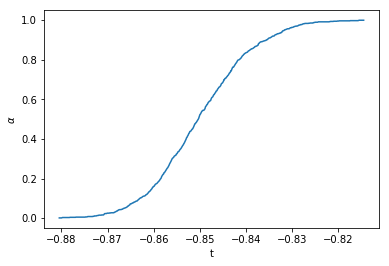

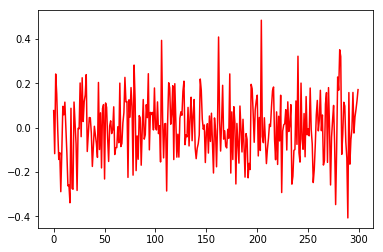

In [657]:
dimension = 300
x = [[random.uniform(-0.1,0) for j in range(dimension)] for i in range(1000)]
centroid =[random.uniform(0.1,0.2) for j in range(dimension)] 
dist = cosine_similarity(x, [centroid])
#dist = euclidean_distances(x, [centroid])
dist = dist.ravel()
#print(dist)
#dist = euclidean_distances(x_vecs, [mean])
res = zip(dist, x)
sort_res = sorted(res,key=lambda res:res[0], reverse=True)
flags = np.array([(t in x) for _, t in sort_res])
flags = np.array([1]*len(dist))
#print(flags)
#for x in sort_res: print(x)
sorted_score = np.array([s for s, _ in sort_res])
sorted_words = np.array([w for _, w in sort_res])
#print(sorted_words[-1])
#print(sorted_score[-1])
#print(sort_res)
percents = []
xr = np.arange(min(sorted_score),max(sorted_score),0.0001)
for thresh in xr:
    cut = flags[np.where(sorted_score <= thresh)]
    sc = 0 if len(cut) == 0 else (sum(cut))/len(x)
    percents.append(sc)
print(min(sorted_score))
print(max(sorted_score))
#print([w for s,w in sort_res if s > 0.65 and w in swords])
#df = pd.DataFrame(dict(x = np.arange(0,1,0.005), score=percents))

#sns.lmplot("x",'score', data=df, fit_reg=False)
plt.plot(xr, percents)
plt.xlabel("t")
plt.ylabel(r"$\alpha$")
plt.show()

plt.plot(word2vec["red"]-stopwords_mean,color = "red")
#plt.hist(word2vec["the"], color = "green", bins = np.arange(-0.2,0.2,0.01))
plt.show()

### 

In [42]:
print([[1,2,3]]+[[2,3,4]])

[[1, 2, 3], [2, 3, 4]]


In [56]:
print(max(1,2))

2


In [28]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.2.4.
The scikit-learn version is 0.19.2.


In [71]:
a = np.array([[1,2,3],[2,3,4]])
b = np.array([0.1,0.2,0.3])
c = b*a
print(np.array([1,2,3])*0.1)

[ 0.1  0.2  0.3]


In [58]:
word2vec.values[:10]

AttributeError: 'Word2VecKeyedVectors' object has no attribute 'values'

In [222]:
n = 2
k = 2
for it in range(10):
    ws = [np.random.rand(n) for i in range(k)]
    c = np.random.rand(n)
    left = sum([np.log(1/(1+np.exp(np.inner(w,c)))) for w in ws])
    right = np.log(1/(1+np.exp(np.inner(np.mean(ws, axis = 0),c)))) * len(ws)
    print("{0:.20f}:{1:.20f}".format(left, right))

-2.61412632494338614819:-2.61012001036739071935
-2.17099497732529211902:-2.16897059824207794065
-2.09003654060507759738:-2.07574640646185981652
-1.64319107358975258215:-1.64121533268962926932
-2.28893596919345920782:-2.27817866320134587710
-2.74225205612611766526:-2.71232655661114874235
-2.04047782167510716178:-2.01269316236395567898
-1.82372422372008902158:-1.82351816052231163745
-1.71653600503356296159:-1.71222887098878584489
-1.74941684482327275418:-1.74741092747888515646


In [194]:
print(np.random.rand(3))

[ 0.78564903  0.91116683  0.45279951]


In [213]:
w = [0.1,0.2,0.1,0.2,0.3]
c = [0.2,0.3,0.5,0.4,0.6]
print(np.log(1/(1+np.exp(np.inner(w,c)))))
print(np.log(1/(1+np.exp(np.inner(np.mean(ws, axis = 0),c)))))

-0.907040396695
-0.907040396695


In [211]:
left = 1
right = 2
print("{}:{}".format(left, right))

1:2


In [26]:
vocab = list(word2vec.vocab.keys())

In [58]:
print(word2vec.similarity("the", "this"))
print(word2vec.similarity("the", "since"))
print(word2vec.similarity("the", "business"))
print(sorted_scores[1])
print(sorted_words[1])

0.593737853085
0.321843315298
0.0918186997544
0.593738
this


In [46]:
scores = [word2vec.similarity(word,"the") for word in vocab]

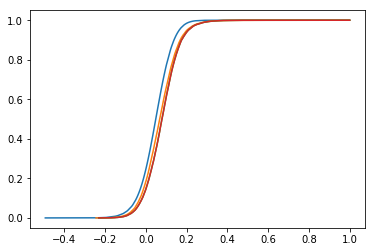

-0.493083307969
1.0


In [78]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
 
    # Number of data points: n
    n=len(data)
 
    # x-data for the ECDF: x
    x=np.sort(data)
 
    # y-data for the ECDF: y
    y=np.arange(1,n+1)/n
 
    return x, y
x, y = ecdf(scores)
plt.plot(x,y)
x, y = ecdf(sport)
plt.plot(x,y)
bbc = sorted_score
x, y = ecdf(bbc)
plt.plot(x,y)
news20 = sorted_score
x, y = ecdf(sorted_score)
plt.plot(x,y)
plt.show()
wpercents = []
sorted_scores = sorted(scores)
wxr = np.arange(min(scores), max(scores),0.01)
print(min(scores))
print(max(scores))
k = 1
pers = []
for i, score in enumerate(sorted_scores):
    if score >k*0.01:
        pers.append(i/len(scores))
        k = k+1

#percents = percents


In [87]:
print(len(sport))
print(len(wxr))
print(len(pers))
x, y = ecdf(scores)
popt, pcov = curve_fit(logistic, x, y)
print(popt)

24864
150
52
[ 0.04845649  0.04251726]


In [60]:
print(word2vec.similar_by_vector(vec_c_all, topn = 100))

[('http_dol##.net_index###.html_http', 0.9355260133743286), ('dol##.net_index####.html_http_dol##.net', 0.9297374486923218), ('index###.html_http_dol##.net_index###.html', 0.9273356795310974), ('By_TRICIA_SCRUGGS', 0.9272603392601013), ('BY_STEFANIE_WHITE', 0.9260945320129395), ('BY_GEOFF_KOHL', 0.9215406775474548), ('http_dol##.net_index####.html_http', 0.9200567603111267), ('SIX_ROG_VX', 0.9199996590614319), ('dol##.net_index###.html_http_dol##.net', 0.9196153283119202), ('REYNOLDS_GALLERY', 0.919133186340332), ('Park_Debate_Colester', 0.9189960360527039), ('By_Ted_Holteen', 0.9188137650489807), ('Emil_Protalinski_Published', 0.9177500009536743), ('By_ROB_BURGESS', 0.9173658490180969), ('BY_DANNY_GALLAGHER', 0.9151509404182434), ('By_JENNIFER_KOVACS', 0.914551854133606), ('Iljitsch_van_Beijnum_Published', 0.9143356680870056), ('By_Matt_Stacionis', 0.9142980575561523), ('By_SALLY_SPAULDING', 0.9141932129859924), ('under_CorMedix_collaborations', 0.9138799905776978), ('By_QianMian_####